# Módulos necesarios

In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=f74b8bebcc413c74c96eddcbda79ba0b70de21b2a5ebd8e12f90774bbb89098e
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 8.6 MB/s eta 0:00:00


In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.2 MB/s eta 0:00:00


# Librerías

In [ ]:
# Importar las librerias
import pandas as pd
import numpy as np
import zipfile
import requests
import matplotlib.pyplot as plt
import warnings
import shap
import lime
import lime.lime_tabular
import scipy.stats as stats

from io import BytesIO
from sklearn import svm as svm

#Clasificadores y básicos
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#Stratified KFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#Clasificadores
  #Linear Model
from sklearn.feature_selection import SelectFromModel

  #Adaboost
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize

  #Naive Bayes
from sklearn.metrics import  classification_report

  #Regresion Logisitca
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

  #Gradiente Boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

#Wilcoxon
from scipy.stats import wilcoxon


#Oversampling and Undersampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score

#Features
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.base import clone
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.cluster import KMeans

#Tecnica Gradient Boosting
from imblearn.over_sampling import SMOTE

#KBest y PCA
from sklearn.feature_selection import  chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score

#SFModel y UMAP
from umap import UMAP

#Comparacion distribuciones
from sklearn.datasets import make_classification
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder



# Tratamiento de los datos


Variable a predecir: readmitted. Buscar y seleccionar modelos con la mayor precisión, utilizando como medida el área bajo Curva Roc mediante la estrategia de validación cruzada de 10 particiones.

In [ ]:

# URL del archivo zip
zip_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip"

# Descargar el archivo zip
response = requests.get(zip_url)
zip_file = zipfile.ZipFile(BytesIO(response.content))

# Extraer el archivo CSV
csv_file = zip_file.open('dataset_diabetes/diabetic_data.csv')
csv_fileID = zip_file.open('dataset_diabetes/IDs_mapping.csv')

# Leer el conjunto de datos
diabetic_data = pd.read_csv(csv_file, na_values="?")  # variable datos
IDs_mapping = pd.read_csv(csv_fileID)  # variable IDs

# Lista de nombres de columnas que deseas eliminar
columnas_a_eliminar = ['encounter_id', 'patient_nbr', 'examide', 'payer_code', 'medical_specialty', 'weight',
                       'max_glu_serum', 'A1Cresult', 'citoglipton']

<ipython-input-5-ebf36809c0c6>:13: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  diabetic_data = pd.read_csv(csv_file, na_values="?")  # variable datos


In [ ]:
# Bucle for para recorrer las columnas
for column in diabetic_data.columns:
    # Calcular los valores únicos en la columna actual
    unique_values = diabetic_data[column].unique()

    # Calcular el porcentaje de filas con el mismo valor único
    most_common_value_percentage = diabetic_data[column].value_counts(normalize=True).max() * 100

    # Agregar la columna a la lista si cumple el criterio
    if most_common_value_percentage > 85:
        columnas_a_eliminar.append(column)


In [ ]:
# Eliminar las columnas utilizando el método drop()
diabetic_data = diabetic_data.drop(columnas_a_eliminar, axis=1)
# Mostrar las cabeceras de las columnas del conjunto de datos
column_headers = diabetic_data.columns
print("La base de datos finalmente contiene las siguientes características: ", column_headers)
column_headersID = IDs_mapping.columns
print("\nHeaders of IDs")
print(column_headersID)

La base de datos finalmente contiene las siguientes características:  Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'metformin', 'insulin', 'change', 'diabetesMed',
       'readmitted'],
      dtype='object')

Headers of IDs
Index(['admission_type_id', 'description'], dtype='object')


## Transformación diag


In [ ]:
def modificar_columna(nombre_columna):
    if nombre_columna in diabetic_data.columns:
        columna = diabetic_data[nombre_columna]
        for indice, valor in columna.items():
            if isinstance(valor, str) and valor.isdigit():
              valor = int(valor)
              if ((valor>=390 and valor<=459) or valor==785):
                diabetic_data.at[indice, nombre_columna] = 'Enfermedad cardiaca'
              elif ((valor>=460 and valor<=519) or valor==786):
                diabetic_data.at[indice, nombre_columna] = 'Enfermedad respiratoria'
              elif ((valor>=520 and valor<=579) or valor==787):
                diabetic_data.at[indice, nombre_columna] = 'Enfermedad respiratoria'
              elif (valor>=250 and valor<251) :
                diabetic_data.at[indice, nombre_columna] = 'Diabetes mellitus'
              elif (valor>=800 and valor<=999):
                diabetic_data.at[indice, nombre_columna] = 'herida y envenamiento'
              elif (valor>= 710 and valor<= 739):
                diabetic_data.at[indice, nombre_columna] = 'enfermedad musculoesqueletica o de tejido conectivo'
              elif ((valor>=580 and valor<=629) or valor==788):
                diabetic_data.at[indice, nombre_columna] = 'Enfermedad genitourinaria'
              elif (valor>= 140 and valor<= 239):
                 diabetic_data.at[indice, nombre_columna] = 'neoplasia'
              elif (valor==780 or valor==781 or valor==784) or (valor>=790 and valor<=799):
                diabetic_data.at[indice, nombre_columna] = 'otros sintomas'
              elif (valor>=240 and valor <250) and (valor>=251 and valor <709):
                diabetic_data.at[indice, nombre_columna] = 'problemas endocrinos, nutriionales o metabolicos sin diabetes'
              elif (valor>=680 and valor<=709) or valor==782:
                diabetic_data.at[indice, nombre_columna] = 'Enfermedades de la piel'
              elif (valor>= 1 and valor<=139):
                diabetic_data.at[indice, nombre_columna] = 'Enfermedad infecciosa o parasitaria'
              elif (valor>=290 and valor<=319):
                diabetic_data.at[indice, nombre_columna] = 'Enfermedad mental'
              elif (valor>=280 and valor <=289):
                diabetic_data.at[indice, nombre_columna] = 'Problemas en la sangre'
              elif (valor>=320 and valor <=359):
                diabetic_data.at[indice, nombre_columna] = 'problemas del sistema nervioso'
              elif (valor>=630 and valor<=679):
                diabetic_data.at[indice, nombre_columna] = 'Complicaciones embarazo'
              elif (valor>=360 and valor<=389):
                diabetic_data.at[indice, nombre_columna] = 'Problemas de los organos de los sentidos'
              elif (valor>=740 and valor<=759):
                diabetic_data.at[indice, nombre_columna] = 'anomalias cognitivas'
              else:
                diabetic_data.at[indice, nombre_columna] = 'otro'
            else:
              diabetic_data.at[indice, nombre_columna] = 'Causa externa'
    else:
        print(f"La columna '{nombre_columna}' no existe en el conjunto de datos.")

modificar_columna('diag_1')
modificar_columna('diag_2')
modificar_columna('diag_3')

In [ ]:
# Mostrar las primeras filas de las cabeceras para poder ver los datos
print(diabetic_data.head())


              race  gender      age  admission_type_id  \
0        Caucasian  Female   [0-10)                  6   
1        Caucasian  Female  [10-20)                  1   
2  AfricanAmerican  Female  [20-30)                  1   
3        Caucasian    Male  [30-40)                  1   
4        Caucasian    Male  [40-50)                  1   

   discharge_disposition_id  admission_source_id  time_in_hospital  \
0                        25                    1                 1   
1                         1                    7                 3   
2                         1                    7                 2   
3                         1                    7                 2   
4                         1                    7                 1   

   num_lab_procedures  num_procedures  num_medications  ...  number_inpatient  \
0                  41               0                1  ...                 0   
1                  59               0               18  ...         

In [ ]:
#Se muestran los datos de las primeras filas de ID
print(IDs_mapping.head())

  admission_type_id    description
0                 1      Emergency
1                 2         Urgent
2                 3       Elective
3                 4        Newborn
4                 5  Not Available


# Variables diagnostico

## Variables númericas y Variables categoricas







Se puede apreciar que en IDs_mapping y diabetic_data hay valores no conocidos representados por NaN. A continuación se separan las variables según si son de tipo numérico y categórico.

In [ ]:
# Mostrar las variables numéricas
print("Variables numéricas:")
print(diabetic_data.select_dtypes(include=['int64', 'float64']).info())

# Mostrar las variables categóricas
print("\nVariables categóricas:")
print(diabetic_data.select_dtypes(include=['object', 'category']).info())

Variables numéricas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   admission_type_id         101766 non-null  int64
 1   discharge_disposition_id  101766 non-null  int64
 2   admission_source_id       101766 non-null  int64
 3   time_in_hospital          101766 non-null  int64
 4   num_lab_procedures        101766 non-null  int64
 5   num_procedures            101766 non-null  int64
 6   num_medications           101766 non-null  int64
 7   number_outpatient         101766 non-null  int64
 8   number_inpatient          101766 non-null  int64
 9   number_diagnoses          101766 non-null  int64
dtypes: int64(10)
memory usage: 7.8 MB
None

Variables categóricas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype 

La variable objetivo es la variable "readmitted". Para poder trabajar y realizar los modelos se guardan los datos de la variable "readmitted" aparte.

In [ ]:
target = diabetic_data["readmitted"]
target.value_counts()

readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

### Variables númericas




Se guardan las variables numéricas en la variable 'diabetic_data_numerical'. A continuación se puede ver los primeros valores de estas con una tabla descriptiva en la que se almacena información al respecto: el número de valores, la media, desviación estándar, valores mínimos y máximos, etc.

In [ ]:
numerical_columns = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_inpatient','number_diagnoses']
diabetic_data_numerical = diabetic_data[numerical_columns] #guardamos las columnas numericas
diabetic_data_numerical.head()


time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
0                 1                  41               0                1   
1                 3                  59               0               18   
2                 2                  11               5               13   
3                 2                  44               1               16   
4                 1                  51               0                8   

   number_outpatient  number_inpatient  number_diagnoses  
0                  0                 0                 1  
1                  0                 0                 9  
2                  2                 1                 6  
3                  0                 0                 7  
4                  0                 0                 5

In [ ]:
diabetic_data_numerical.describe()

time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
count     101766.000000       101766.000000   101766.000000    101766.000000   
mean           4.395987           43.095641        1.339730        16.021844   
std            2.985108           19.674362        1.705807         8.127566   
min            1.000000            1.000000        0.000000         1.000000   
25%            2.000000           31.000000        0.000000        10.000000   
50%            4.000000           44.000000        1.000000        15.000000   
75%            6.000000           57.000000        2.000000        20.000000   
max           14.000000          132.000000        6.000000        81.000000   

       number_outpatient  number_inpatient  number_diagnoses  
count      101766.000000     101766.000000     101766.000000  
mean            0.369357          0.635566          7.422607  
std             1.267265          1.262863          1.933600  
min             0.000000          0.000000          1.000000  
25%             0.000000          0.000000          6.000000  
50%             0.000000          0.000000          8.000000  
75%             0.000000          1.000000          9.000000  
max            42.000000         21.000000         16.000000

### Variables Categóricas

Se define la variable objetivo gracias a la etiqueta 'target_name'y se guarda en 'target'. Esta es la variable que se desea predecir, hace referencia a la posibilidad de ser reingresado. Se separa la variable objetivo del resto de las características, se realiza para no utilizar la variable objetivo en las características de entrada que se utilizaran posteriormente para el entrenamiento del modelo.

In [ ]:
target_name = "readmitted"
target = diabetic_data[target_name]

diabetic_data = diabetic_data.drop(columns=[target_name]) #se elimina la variable objetivo de la base de datos
#selecciona y almacena las tipo categorical
data_categorical = diabetic_data.select_dtypes([object])
categorical_columns = data_categorical.columns
data_categorical.head()

race  gender      age                               diag_1  \
0        Caucasian  Female   [0-10)                        Causa externa   
1        Caucasian  Female  [10-20)                                 otro   
2  AfricanAmerican  Female  [20-30)              Complicaciones embarazo   
3        Caucasian    Male  [30-40)  Enfermedad infecciosa o parasitaria   
4        Caucasian    Male  [40-50)                            neoplasia   

              diag_2               diag_3 metformin insulin change diabetesMed  
0      Causa externa        Causa externa        No      No     No          No  
1      Causa externa                 otro        No      Up     Ch         Yes  
2  Diabetes mellitus        Causa externa        No      No     No         Yes  
3      Causa externa  Enfermedad cardiaca        No      Up     Ch         Yes  
4          neoplasia    Diabetes mellitus        No  Steady     Ch         Yes

Para realizar las conversiones del tipo de dato se crea un diccionarios cuyas claves son los nombres de la columnas, utilizandolo se convierten las columnas categóricas,que ya se han almacenado previamente en una variable para conocer cuáles son, al tipo de dato 'categórico'. Se crea un DataFrame, con el mismo indice y columnas que la variable que almacena los datos categoricos. Este DataFrame almacena códigos numéricos de las categorias, se asignan mediante el mediante '.cat.codes'.
Finalmente se representa el tipo de datos de cada variable.

In [ ]:
dict_cat = {i:'category' for i in categorical_columns}  #creacción del diccionario.
diabetic_data_categorical = diabetic_data[categorical_columns].astype(dict_cat) #conversion columnas 'categóricas' al tipo de dato 'categórico.'

diabetic_data_categorical_codes = pd.DataFrame(   #Crea DataFrame
    index = diabetic_data_categorical.index,
    columns = diabetic_data_categorical.columns)

for i in diabetic_data_categorical.columns:#guarda los códigos numéricos
  diabetic_data_categorical_codes[i] = diabetic_data_categorical[i].cat.codes

#diabetic_data_categorical = diabetic_data_categorical_codes
print(diabetic_data_categorical_codes.head())
diabetic_data_categorical_codes.dtypes#imprime el tipo de datos

#creo una nueva base de datos con los nuevos datos
data= pd.concat([diabetic_data_numerical,diabetic_data_categorical_codes], axis=1)

   race  gender  age  diag_1  diag_2  diag_3  metformin  insulin  change  \
0     2       0    0       0       0       0          1        1       1   
1     2       0    1      15       0      15          1        3       0   
2     0       0    2       1       2       0          1        1       1   
3     2       1    3       5       0       3          1        3       0   
4     2       1    4      14      14       2          1        2       0   

   diabetesMed  
0            0  
1            1  
2            1  
3            1  
4            1  


Mapeo de las etiquetas y valores de las variables categoricas convertidas

In [ ]:
# Itera sobre cada columna categórica en el DataFrame de códigos numéricos y el DataFrame original
for columna in diabetic_data_categorical_codes:
    valores_unicos_codes = diabetic_data_categorical_codes[columna].unique()
    valores_unicos = diabetic_data_categorical[columna].unique()
    print(f"\nValores únicos de la columna '{columna}':")

    # Crea un diccionario de correspondencia entre códigos numéricos y etiquetas
    mapeo_correspondencia = {}
    for codigo, etiqueta in zip(valores_unicos_codes, valores_unicos):
        mapeo_correspondencia[codigo] = etiqueta

    print(f"Correspondencia entre códigos numéricos y etiquetas para la columna '{columna}':")
    for codigo, etiqueta in mapeo_correspondencia.items():
        print(f"{codigo}: {etiqueta}")



Valores únicos de la columna 'race':
Correspondencia entre códigos numéricos y etiquetas para la columna 'race':
2: Caucasian
0: AfricanAmerican
-1: nan
4: Other
1: Asian
3: Hispanic

Valores únicos de la columna 'gender':
Correspondencia entre códigos numéricos y etiquetas para la columna 'gender':
0: Female
1: Male
2: Unknown/Invalid

Valores únicos de la columna 'age':
Correspondencia entre códigos numéricos y etiquetas para la columna 'age':
0: [0-10)
1: [10-20)
2: [20-30)
3: [30-40)
4: [40-50)
5: [50-60)
6: [60-70)
7: [70-80)
8: [80-90)
9: [90-100)

Valores únicos de la columna 'diag_1':
Correspondencia entre códigos numéricos y etiquetas para la columna 'diag_1':
0: Causa externa
15: otro
1: Complicaciones embarazo
5: Enfermedad infecciosa o parasitaria
14: neoplasia
3: Enfermedad cardiaca
7: Enfermedad respiratoria
13: herida y envenamiento
8: Enfermedades de la piel
12: enfermedad musculoesqueletica o de tejido conectivo
4: Enfermedad genitourinaria
6: Enfermedad mental
16: ot

# División de datos de entramiento y prueba a partir del conjunto de datos

In [ ]:
# División de datos de entrenamiento y prueba
data_train, data_test, target_train, target_test = train_test_split(data, target, random_state=42, test_size=0.25)


# DummyClassifier (clasificador base)
Se ha utilizado un modelo base para obtener los resultados con los que se podrá valorar si los siguientes clasificadores mejoran la predicción.

In [ ]:
# Crear y ajustar el clasificador Dummy
dummy_clf = DummyClassifier(strategy="most_frequent")  # Puede ser "most_frequent", "stratified", "uniform", o "constant"
dummy_clf.fit(data_train, target_train)

# Calcular la precisión del clasificador Dummy
y_pred = dummy_clf.predict(data_test)
accuracy = accuracy_score(target_test, y_pred)
print("Predicción del Dummy Classifier:", y_pred)
print("Precisión del Dummy Classifier:", accuracy)

# Obtener las probabilidades predichas del clasificador Dummy
y_proba_dummy = dummy_clf.predict_proba(data_test)

# Calcula el AUC para cada clase versus el resto
auc_scores_dummy = roc_auc_score(target_test, y_proba_dummy, multi_class='ovr')

# Imprime los AUC scores para cada clase
print("AUC scores for each class (Dummy Classifier):", auc_scores_dummy)



Predicción del Dummy Classifier: ['NO' 'NO' 'NO' ... 'NO' 'NO' 'NO']
Precisión del Dummy Classifier: 0.5374970521185441
AUC scores for each class (Dummy Classifier): 0.5


# Clasificadores

Al inicio se comenzó a realizar los clasificadores con toda la base de datos una vez se observó que tardaban demasiado tiempo en ejecutarse comprendimos que la base de datos era necesario limpiarla aún más y por ello se eliminaron las columnas que tenian un gran porcetaje de valores nulos

En primer lugar se dividen los datos en un conjunto de entrenamiento y un conjunto de prueba formado el primero por data_train y target_train, y el segundo por data_test y target_test. Después se imprime el numero de muestras, en valor absoluto y relación al tamaño del conjunto original. Se crea y ajusta un clasificador que predice la clase más frecuente.
Esta predicción concretamente es calculada con la comparación de las predicciones con las etiquetas reales 'target_test' mediante la métrica de precisión 'accuracy_score'.

Se obtiene un valor de 0.53 de precisión que hace referencia a la medida de exactitud de un modelo predictivo o clasificador. Aproximadamente un 53.75% de las predicciones realizadas son correctas en comparación con el total de predicciones realizadas.
Seguidamente se obtiene la proporción de cada clase de la variable objetivo en el conjunto de datos de entramiento.

No tiene pesos

In [ ]:
target_train.value_counts(normalize=True)

readmitted
NO     0.539660
>30    0.348868
<30    0.111472
Name: proportion, dtype: float64

## Linear Model

Se crea una instancia del modelo de regresión logística, se entrena el modelo con los datos de entrenamiento 'data_train', y 'target_train' (etiquetas correspondientes' mediante el método .fit().
Linear_regression_coef[0] representa la pendiente estimada de la caracteristica del modelo, linear_regression_coef es un array de coeficientes. Por otro lado linear_regression.intercept_ se refiere al termino de intercepcion estimado en el modelo de regresión lineal, es el valor de la variable dependiente(valor predicho), cuando todas las independientes son cero.

Precisión del modelo: 0.5666208116340768
Pesos de las características:
time_in_hospital      0.042069
num_lab_procedures   -0.005832
num_procedures       -0.023511
num_medications       0.028931
number_outpatient     0.004984
number_inpatient      0.268610
number_diagnoses      0.037693
race                  0.002755
gender                0.007336
age                   0.029849
diag_1               -0.015361
diag_2                0.011922
diag_3                0.009485
metformin            -0.038086
insulin              -0.021939
change               -0.001607
diabetesMed           0.052482
dtype: float64


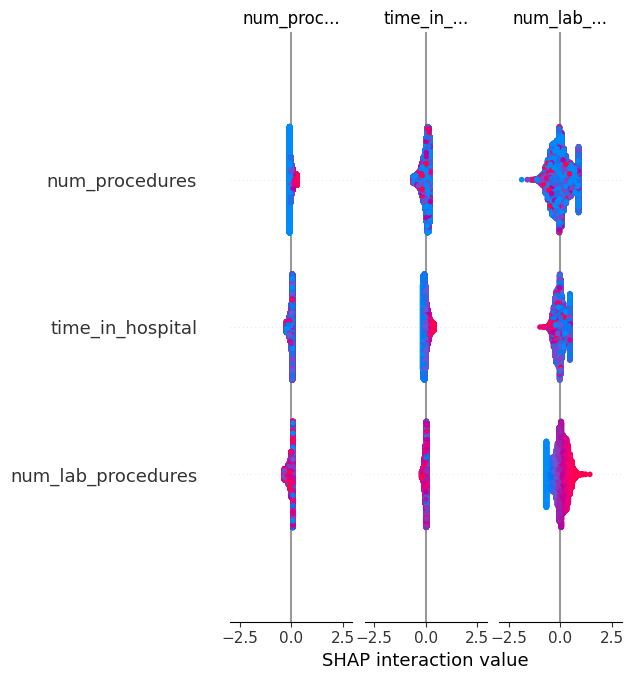

AUC scores for each class (Logistic Regression): 0.6332430890672615


In [ ]:
#Muestreo aleatorio estratificado
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)

# Selección de características y entrenamiento del modelo
logistic_regression = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=5000, penalty=None)
)
logistic_regression.named_steps['logisticregression'].feature_names = data.columns.tolist()

logistic_regression.fit(data_train, target_train)

# Evaluación del modelo
predictions = logistic_regression.predict(data_test)
accuracy = accuracy_score(target_test, predictions)
print("Precisión del modelo:", accuracy)


# Obtención de los coeficientes del modelo de regresión logística
logistic_regression_model = logistic_regression[-1]  # Obtenemos el último estimador (regresión logística) del pipeline
coefs = logistic_regression_model.coef_[0]  # Obtenemos los coeficientes del modelo

# Convertir los coeficientes en una Serie de pandas con los nombres de las características como índices
weights = pd.Series(coefs, index=data.columns)

print("Pesos de las características:")
print(weights)

# Interpretación del modelo con SHAP
explainer = shap.Explainer(logistic_regression_model, data_train)
shap_values = explainer.shap_values(data_test)

# Visualización de los valores SHAP
shap.summary_plot(shap_values, data_test)

# Paso 6: Interpretación del modelo con LIME
explainer_lime = lime.lime_tabular.LimeTabularExplainer(data_train.values, feature_names=data.columns)
lime_explanation = explainer_lime.explain_instance(data_test.iloc[0].values, logistic_regression.predict_proba, num_features=len(data.columns))
lime_explanation.show_in_notebook()

# Paso 7: Cálculo del AUC para cada clase versus el resto
predictions_auc = logistic_regression.predict_proba(data_test)
auc_score = roc_auc_score(target_test, predictions_auc, multi_class='ovr', average='macro')

# Imprime los AUC scores para cada clase
print("AUC scores for each class (Logistic Regression):", auc_score)



auc 0.6354
precision 0.56711
//Precisión del modelo: 0.569028200845042
AUC scores for each class (Lineal Classifier): 0.636727629577456

En este código, logistic_regression[-1] accede al último estimador (la regresión logística) en el pipeline, y luego logistic_regression_model.coef_[0] obtiene los coeficientes del modelo de regresión logística. Finalmente, creamos una Serie de pandas con los coeficientes y los nombres de las características como índices.







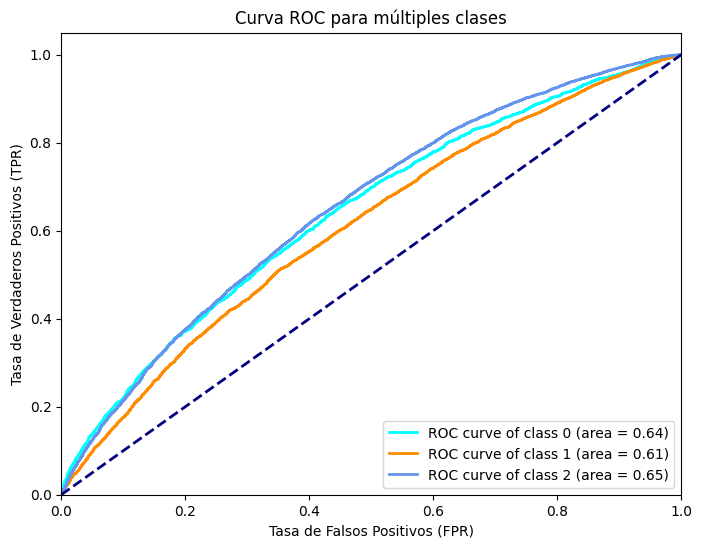

In [ ]:
# Obtener las probabilidades predichas para cada clase
predictions_prob = logistic_regression.predict_proba(data_test)

# Obtener la representación de una matriz de clases de 3 columnas
target_dummy = pd.get_dummies(target_test, columns=np.unique(target_test))

# Calcular el AUC para cada clase frente a las otras dos
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(target_dummy.columns)):
    fpr[i], tpr[i], _ = roc_curve(target_dummy.iloc[:, i], predictions_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Dibujar la curva ROC para cada clase
plt.figure(figsize=(8, 6))

colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(len(target_dummy.columns)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para múltiples clases')
plt.legend(loc="lower right")
plt.show()


### Mejora de los hiperparametros de forma manual

C: El parámetro C controla la fuerza de la regularización en la regresión logística. Un valor más bajo de C implica una regularización más fuerte, lo que puede ayudar a prevenir el sobreajuste, especialmente si tienes un gran número de características en tu conjunto de datos. Experimenta con diferentes valores de C para encontrar el equilibrio adecuado entre el sesgo y la varianza.

penalty: El tipo de regularización (L1 o L2) especificado por el parámetro penalty puede afectar al rendimiento del modelo. Por lo general, la regularización L2 (penalty='l2') se prefiere por su capacidad para manejar mejor la multicolinealidad entre las características, pero en algunos casos la regularización L1 (penalty='l1') puede ser útil para la selección de características y la reducción de dimensionalidad.

solver: El algoritmo de optimización especificado por el parámetro solver puede influir en la convergencia y el rendimiento del modelo. Algunos solvers, como "liblinear" y "saga", son más adecuados para problemas de regularización L1, mientras que otros, como "lbfgs" y "newton-cg", son más adecuados para la regularización L2. Experimenta con diferentes solvers para ver cuál funciona mejor para tu conjunto de datos y configuración de hiperparámetros.

max_iter: El número máximo de iteraciones especificado por max_iter puede necesitar ser ajustado si el modelo no converge con el número predeterminado de iteraciones. Aumentar este valor puede permitir que el modelo converja a una solución óptima, especialmente si tienes un gran conjunto de datos o si estás utilizando una configuración de hiperparámetros que requiere más iteraciones para converger.

**Resultados del modelo con solver='liblinear' y penalty='l1':**
*  Precisión del modelo: 0.5677999410435295
* AUC score del modelo: 0.6324644859742447

**Resultados del modelo con solver='saga' y penalty='l1':**
* Precisión del modelo: 0.5690282008450428
* AUC score del modelo: 0.6347668500835021

**Resultados del modelo con solver='lbfgs' y penalty='l2':**
* Precisión del modelo: 0.5690282008450428
* AUC score del modelo: 0.6347677418176755

**Resultados del modelo con solver='newton-cg' y penalty='l2':**

* Precisión del modelo: 0.5690282008450428
* AUC score del modelo: 0.6347665816249027

In [ ]:
#hyperparametres
hyperparametres = {
    'l1': ['liblinear', 'saga'],
    'l2': ['lbfgs', 'newton-cg']
}

# Listas para almacenar los resultados de precisión y AUC
accuracy_scores = []
auc_scores = []

# Iterar sobre las combinaciones válidas de hiperparámetros
for penalty, solvers in hyperparametres.items():
    for solver in solvers:
      for max_iter in [100, 1000, 10000]:  # Valores de max_iter a probar
            # Inicializar el modelo de regresión logística con los hiperparámetros actuales
            logistic_regression_model = make_pipeline(
            StandardScaler(),
            LogisticRegression(max_iter=max_iter, penalty=penalty, solver=solver, random_state=42)
            )
            logistic_regression_model.fit(data_train, target_train)
            y_pred = logistic_regression_model.predict(data_test)
            y_proba = logistic_regression_model.predict_proba(data_test)

            # Calcular la precisión y el AUC
            accuracy = accuracy_score(target_test, y_pred)
            auc_score = roc_auc_score(target_test, y_proba, multi_class='ovr')

            # Guardar los resultados en las listas
            accuracy_scores.append(accuracy)
            auc_scores.append(auc_score)

            print(f"Resultados del modelo con solver='{solver}', penalty='{penalty}', max_iter={max_iter}:")
            print("Precisión del modelo:{:.4f}".format(accuracy))
            print("AUC score del modelo:{:.4f}".format(auc_score))

# Imprimir la lista de precisión y AUC para cada combinación de hiperparámetros
print("Lista de precisión para cada combinación de hiperparámetros: {}",accuracy_scores)
print("Lista de AUC para cada combinación de hiperparámetros: ",auc_scores)

Resultados del modelo con solver='liblinear', penalty='l1', max_iter=100:
Precisión del modelo:0.5645
AUC score del modelo:0.6317
Resultados del modelo con solver='liblinear', penalty='l1', max_iter=1000:
Precisión del modelo:0.5645
AUC score del modelo:0.6317
Resultados del modelo con solver='liblinear', penalty='l1', max_iter=10000:
Precisión del modelo:0.5645
AUC score del modelo:0.6317
Resultados del modelo con solver='saga', penalty='l1', max_iter=100:
Precisión del modelo:0.5666
AUC score del modelo:0.6332
Resultados del modelo con solver='saga', penalty='l1', max_iter=1000:
Precisión del modelo:0.5666
AUC score del modelo:0.6332
Resultados del modelo con solver='saga', penalty='l1', max_iter=10000:
Precisión del modelo:0.5666
AUC score del modelo:0.6332
Resultados del modelo con solver='lbfgs', penalty='l2', max_iter=100:
Precisión del modelo:0.5666
AUC score del modelo:0.6332
Resultados del modelo con solver='lbfgs', penalty='l2', max_iter=1000:
Precisión del modelo:0.5666
AUC 

## AdaBoost

In [ ]:
# Supongamos que tienes tus datos en variables data y target
# data es tu matriz de características y target es tu vector de etiquetas

# División de datos de entrenamiento y prueba
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Inicializar el clasificador AdaBoost
adaboost_classifier = AdaBoostClassifier()
print("Los hiperparametros que utiliza este modelo son:")
print("base_estimator: ",adaboost_classifier.base_estimator)
print("n_estimators: ",adaboost_classifier.n_estimators)
print("learning_rate: ",adaboost_classifier.learning_rate)
# Entrenar el clasificador
adaboost_classifier.fit(data_train, target_train)

# Obtener los pesos de los estimadores base utilizados internamente por el clasificador AdaBoost
base_estimator_weights = np.array(adaboost_classifier.estimator_weights_)

print("Pesos de los estimadores base para AdaBoost:")
print(base_estimator_weights)

# Predecir en el conjunto de prueba
y_pred = adaboost_classifier.predict(data_test)

# Calcular la precisión del clasificador
accuracy = accuracy_score(target_test, y_pred)
print("Precisión del modelo AdaBoost:", accuracy)

predictions_auc = adaboost_classifier.predict_proba(data_test)
auc_scores_adabost = roc_auc_score(target_test, predictions_auc, multi_class='ovr')

# Imprime los AUC scores para cada clase
print("AUC scores for each class (AdaBoost):", auc_scores_adabost)


Los hiperparametros que utiliza este modelo son:
base_estimator:  deprecated
n_estimators:  50
learning_rate:  1.0
Pesos de los estimadores base para AdaBoost:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
Precisión del modelo AdaBoost: 0.5726147194654614
AUC scores for each class (AdaBoost): 0.6343663644322038


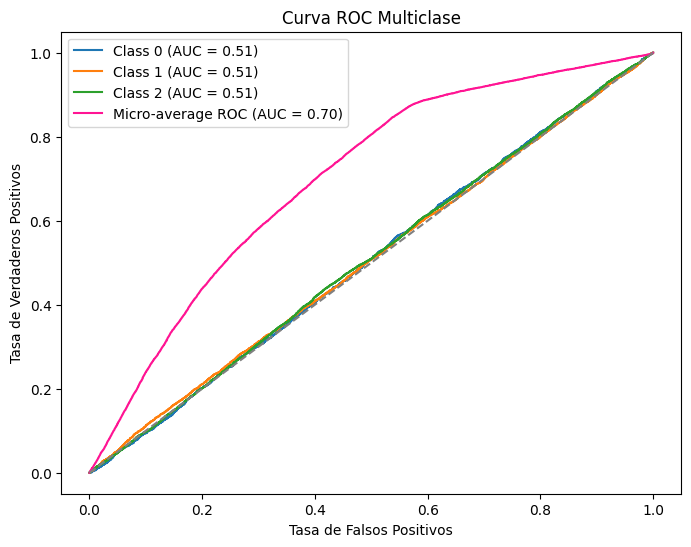

In [ ]:
# Binarizar las etiquetas de clase
lb = LabelBinarizer()
target_test_bin = lb.fit_transform(target_test)

# Calcula la curva ROC y el área bajo la curva (AUC) para cada clase
fpr = {}
tpr = {}
roc_auc = {}
num_classes = target_test_bin.shape[1]

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(target_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcula el micro-average ROC y AUC
fpr["micro"], tpr["micro"], _ = roc_curve(target_test_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Visualiza las curvas ROC para cada clase y el micro-average ROC
plt.figure(figsize=(8, 6))

# Curvas ROC para cada clase
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Curva ROC micro-average
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})', color='deeppink', linestyle='-')

# Estilo y etiquetas
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Curva ROC Multiclase')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend()
plt.show()

prescision 0.5746
auc .6397
//
precision 0.5720
auc 0.6373941

este metodo no cambia los pesos de las clases

obtenemos los pesos de los estimadores base utilizados internamente por el clasificador AdaBoost con el atributo estimator_weights_. Estos pesos reflejan la contribución relativa de cada estimador base en el clasificador AdaBoost final.

### Mejora de los hiperparametros de forma manual
Los principales hiperparámetros son:

**n_estimators**: Especifica el número de estimadores base (por defecto, árboles de decisión débiles) en el ensemble. Un valor más alto de *n_estimators* puede mejorar el rendimiento del modelo, pero también aumenta el tiempo de entrenamiento y el riesgo de sobreajuste.

**learning_rate**: Controla la contribución de cada clasificador base al modelo final. Un valor más bajo de *learning_rate* significa que los clasificadores contribuyen menos al modelo final, lo que puede ayudar a evitar el sobreajuste. Sin embargo, esto generalmente requiere un valor más alto de *n_estimators*.

**base_estimator**: Especifica el tipo de clasificador débil que se utilizará en el ensemble. Por defecto, se utiliza un árbol de decisión con profundidad 1 (un árbol de decisión débil). Se puede especificar cualquier otro clasificador débil para adaptarse mejor a los datos.
Los resultados de la busqueda de hiperparametros de forma manual es la siguiente:

La primera modificación es n_estimators:  200 y un learning_rate:  0.8
Precisión del modelo AdaBoost con la primera modificación.:0.5739
AUC scores for each class (AdaBoost) con la primera modificación.:0.6403
La segunda modificación es n_estimators:  350 y un learning_rate:  0.5
Precisión del modelo AdaBoost con la segunda modificación.:0.5751
AUC scores for each class (AdaBoost) con la segunda modificación.:0.6409

Se puede observar una tendencia ascendente de el accuracy la AUC, se aumenta el n_estimators y el learning rate

In [ ]:

# Definir los valores de n_estimators y learning_rate a probar
n_estimators_values = [200, 350]
learning_rate_values = [0.8, 0.5]
# Listas para almacenar la precisión y el AUC para cada combinación de hiperparámetros
accuracy_scores = []
auc_scores = []

for n_estimators in n_estimators_values:
    for learning_rate in learning_rate_values:
        # Inicializar el clasificador AdaBoost con los hiperparámetros actuales
        adaboost_classifier = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
        adaboost_classifier.fit(data_train, target_train)
        y_pred = adaboost_classifier.predict(data_test) # Predecir en el conjunto de prueba

        # Calcular la precisión del clasificador
        accuracy = accuracy_score(target_test, y_pred)
        accuracy_scores.append(accuracy)

        # Calcular el AUC con el clasificador
        predictions_auc = adaboost_classifier.predict_proba(data_test)
        auc_score = roc_auc_score(target_test, predictions_auc, multi_class='ovr')
        auc_scores.append(auc_score)

        print(f"Resultados del clasificador con n_estimators = {n_estimators} y learning_rate = {learning_rate}:")
        print("Precisión del modelo AdaBoost: {:.4f}".format(accuracy))
        print("AUC scores for each class (AdaBoost): {:.4f}".format(auc_score))


print("Lista de precisión para cada combinación de hiperparámetros:", accuracy_scores)
print("Lista de AUC para cada combinación de hiperparámetros:", auc_scores)


Resultados del clasificador con n_estimators = 200 y learning_rate = 0.8:
Precisión del modelo AdaBoost: 0.5732
AUC scores for each class (AdaBoost): 0.6371
Resultados del clasificador con n_estimators = 200 y learning_rate = 0.5:
Precisión del modelo AdaBoost: 0.5739
AUC scores for each class (AdaBoost): 0.6377
Resultados del clasificador con n_estimators = 350 y learning_rate = 0.8:
Precisión del modelo AdaBoost: 0.5734
AUC scores for each class (AdaBoost): 0.6369
Resultados del clasificador con n_estimators = 350 y learning_rate = 0.5:
Precisión del modelo AdaBoost: 0.5734
AUC scores for each class (AdaBoost): 0.6375
Lista de precisión para cada combinación de hiperparámetros: [0.5731551537781272, 0.573892109659035, 0.5733516753463692, 0.5734008057384298]
Lista de AUC para cada combinación de hiperparámetros: [0.6371316868338369, 0.637747842974494, 0.6368677910898733, 0.6374933143653463]


In [ ]:
warnings.filterwarnings('ignore')
# Definir la cuadrícula de hiperparámetros
param_grid = {
    'n_estimators': [175, 250, 350],
    'learning_rate': [0.1, 0.5, 0.4]
}

# Inicializar la búsqueda en cuadrícula
grid_search = GridSearchCV(adaboost_classifier, param_grid, cv=5, scoring='roc_auc')

# Entrenar la búsqueda en cuadrícula en los datos de entrenamiento
grid_search.fit(data_train, target_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Obtener el mejor estimador (clasificador AdaBoost) encontrado
best_adaboost_classifier = grid_search.best_estimator_

# Evaluación del modelo con los mejores hiperparámetros en el conjunto de prueba
accuracy = best_adaboost_classifier.score(data_test, target_test)
print("Precisión del modelo con mejores hiperparámetros:", accuracy)




Mejores hiperparámetros: {'learning_rate': 0.1, 'n_estimators': 175}
Precisión del modelo con mejores hiperparámetros: 0.5696177655497691


## Naive bayes

In [ ]:
# Inicializar el clasificador Naive Bayes
nb_classifier = GaussianNB()

# Entrenar el clasificador
nb_classifier.fit(data_train, target_train)

# Predecir en el conjunto de prueba
y_pred = nb_classifier.predict(data_test)

# Calcular la precisión del clasificador
accuracy = accuracy_score(target_test, y_pred)
print("Accuracy:", accuracy)

# Mostrar el reporte de clasificación
print("Classification Report:")
print(classification_report(target_test, y_pred))

# Predecir las probabilidades en el conjunto de prueba
y_proba = nb_classifier.predict_proba(data_test)

# Calcular el AUC para cada clase versus el resto
auc_scores = roc_auc_score(target_test, y_proba, multi_class='ovr')

# Imprimir los AUC scores para cada clase
print("AUC scores")
print(auc_scores)

Accuracy: 0.557335167534637
Classification Report:
              precision    recall  f1-score   support

         <30       0.32      0.09      0.14      2285
         >30       0.47      0.20      0.28      7117
          NO       0.58      0.89      0.70     10952

    accuracy                           0.56     20354
   macro avg       0.46      0.39      0.37     20354
weighted avg       0.51      0.56      0.49     20354

AUC scores
0.620248440795854


precision 0.5036
auc 0.6147
// precision 0.113095
auc 0.581035

El clasificador Naive Bayes no tiene coeficientes o pesos como otros modelos lineales. Se basa en la probabilidad condicional de las características dadas las clases para hacer predicciones. Por lo tanto, no se pueden obtener pesos de características como en modelos lineales.

## Random Forest

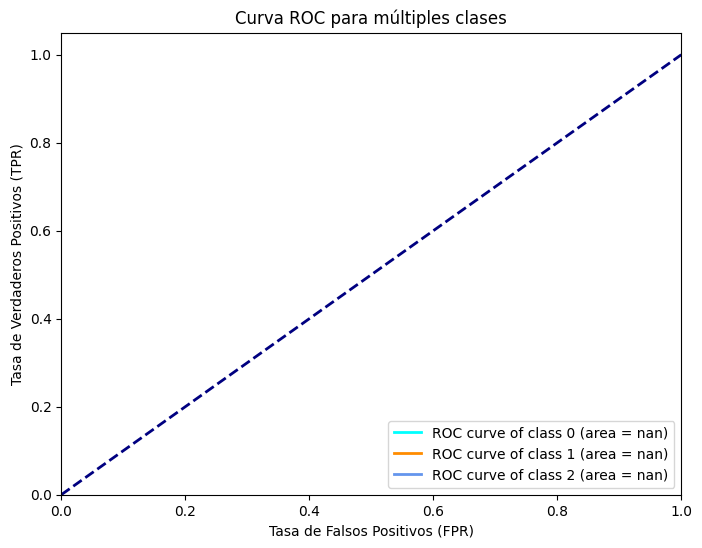

Pesos de las características:
               Feature  Importance
0     time_in_hospital    0.087097
1   num_lab_procedures    0.153917
2       num_procedures    0.050984
3      num_medications    0.126346
4    number_outpatient    0.021222
5     number_inpatient    0.047790
6     number_diagnoses    0.051442
7                 race    0.034235
8               gender    0.027677
9                  age    0.068561
10              diag_1    0.076092
11              diag_2    0.085547
12              diag_3    0.086957
13           metformin    0.019924
14             insulin    0.037324
15              change    0.016786
16         diabetesMed    0.008100
0.623616804952343


In [ ]:
# Inicializar el clasificador Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Entrenar el clasificador
rf_classifier.fit(data_train, target_train)

# Predecir en el conjunto de prueba
y_proba_rf = rf_classifier.predict_proba(data_test)

# Calcular el AUC para cada clase frente a las otras dos
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(np.unique(target_test))):
    fpr[i], tpr[i], _ = roc_curve((target_test == i).astype(int), y_proba_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Dibujar la curva ROC para cada clase
plt.figure(figsize=(8, 6))

colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(len(np.unique(target_test))), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para múltiples clases')
plt.legend(loc="lower right")
plt.show()

# Obtener los pesos de las características
feature_importances = rf_classifier.feature_importances_

# Convertir los pesos de las características en un DataFrame de pandas con los nombres de las características
feature_importance_df = pd.DataFrame({'Feature': data.columns, 'Importance': feature_importances})

print("Pesos de las características:")
print(feature_importance_df)


auc_scores = roc_auc_score(target_test, y_proba_rf, multi_class='ovr')
print(auc_scores)

auc 0.62946

## Arbol de decision


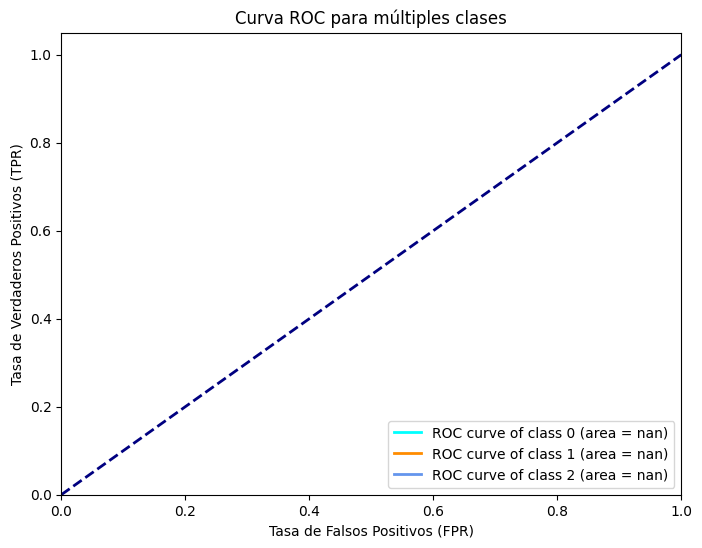

0.5298838365725059


In [ ]:
# Inicializar el clasificador Árbol de Decisión
tree_classifier = DecisionTreeClassifier(random_state=42)

# Entrenar el clasificador
tree_classifier.fit(data_train, target_train)

# Predecir las probabilidades en el conjunto de prueba
y_proba_tree = tree_classifier.predict_proba(data_test)

# Calcular el AUC para cada clase frente a las otras dos
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(np.unique(target_test))):
    fpr[i], tpr[i], _ = roc_curve((target_test == i).astype(int), y_proba_tree[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Dibujar la curva ROC para cada clase
plt.figure(figsize=(8, 6))

colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(len(np.unique(target_test))), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para múltiples clases')
plt.legend(loc="lower right")
plt.show()

auc_scores = roc_auc_score(target_test, y_proba_tree, multi_class='ovr')
print(auc_scores)

auc 0.5321

Pesos

Para obtener los pesos de características de un clasificador de árbol de decisión en Scikit-learn, necesitas acceder a los atributos feature_importances_, que indican la importancia de cada característica para la toma de decisiones del árbol. Aquí está cómo puedes hacerlo:

In [ ]:
# Obtener el modelo de regresión logística del pipeline
logistic_regression_model = logistic_regression.named_steps['logisticregression']

# Obtener los coeficientes del modelo de regresión logística
coefs = logistic_regression_model.coef_[0]  # Los coeficientes son una matriz 2D

# Crear una Serie de pandas con los pesos de las características
weights = pd.Series(coefs, index=data_train.columns)

print("Pesos de las características:")
print(weights)


Pesos de las características:
time_in_hospital      0.042069
num_lab_procedures   -0.005832
num_procedures       -0.023511
num_medications       0.028931
number_outpatient     0.004984
number_inpatient      0.268610
number_diagnoses      0.037693
race                  0.002755
gender                0.007336
age                   0.029849
diag_1               -0.015361
diag_2                0.011922
diag_3                0.009485
metformin            -0.038086
insulin              -0.021939
change               -0.001607
diabetesMed           0.052482
dtype: float64


## Gradiente Boosting


El algoritmo Gradient Boosting requiere varios parámetros para su inicialización. Aquí hay una explicación de los parámetros utilizados en el ejemplo:

n_estimators: Este parámetro indica el número de árboles de decisión que se utilizarán en el proceso de boosting. Un mayor número de estimadores puede conducir a un mejor rendimiento del modelo, pero también aumenta el tiempo de entrenamiento y el riesgo de sobreajuste.
learning_rate: Este parámetro controla la contribución de cada árbol a la corrección de los errores cometidos por los árboles anteriores durante el proceso de boosting. Una tasa de aprendizaje más baja generalmente requiere un mayor número de estimadores para alcanzar un rendimiento similar, pero puede conducir a un modelo más robusto.
random_state: Este parámetro se utiliza para fijar la semilla aleatoria y garantizar la reproducibilidad de los resultados. Al fijar el estado aleatorio, aseguramos que el modelo se inicialice de la misma manera en cada ejecución, lo que facilita la comparación de resultados.

In [ ]:
# Inicializar el clasificador Gradient Boosting
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Entrenar el clasificador
gb_classifier.fit(data_train, target_train)

# Realizar predicciones en el conjunto de prueba
y_pred = gb_classifier.predict(data_test)

y_proba = gb_classifier.predict_proba(data_test)
print("Resultados del clasificador con n_estimators = 100 y learning_rate = 0.1")
# Calcular la precisión
accuracy = accuracy_score(target_test, y_pred)
print("Precisión del clasificador Gradient Boosting: {:.4f}".format(accuracy))

auc_scores = roc_auc_score(target_test, y_proba, multi_class='ovr')
print("Roc AUC score: {:.4f}".format(auc_scores))

Resultados del clasificador con n_estimators = 100 y learning_rate = 0.1
Precisión del clasificador Gradient Boosting: 0.5747
Roc AUC score: 0.6460


### Mejora de los hiperparametros

In [ ]:
# Definir los valores de n_estimators y learning_rate a probar
n_estimators_values = [200, 350]
learning_rate_values = [0.2, 0.8]

# Lista para almacenar las pares de precisión y AUC
results = []

# Iterar sobre los valores
for n_estimators in n_estimators_values:
    for learning_rate in learning_rate_values:
        # Crear el clasificador Gradient Boosting con los valores actuales
        gb_classifier = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
        gb_classifier.fit(data_train, target_train)

        # Realizar predicciones en el conjunto de prueba
        y_pred = gb_classifier.predict(data_test)
        y_proba = gb_classifier.predict_proba(data_test)

        # Calcular la precisión
        accuracy = accuracy_score(target_test, y_pred)
        # Calcular el área bajo la curva ROC
        auc_scores = roc_auc_score(target_test, y_proba, multi_class='ovr')

        # Guardar la pareja de precisión y AUC en la lista
        results.append((accuracy, auc_scores))

        print(f"Resultados del clasificador con n_estimators = {n_estimators} y learning_rate = {learning_rate}")
        print("Precisión del clasificador Gradient Boosting modificado: {:.4f}".format(accuracy))
        print("Roc AUC score modificado : {:.4f}".format(auc_scores))

# Imprimir la lista de resultados
print("Lista de resultados (accuracy, auc_score):", results)


Resultados del clasificador con n_estimators = 200 y learning_rate = 0.2
Precisión del clasificador Gradient Boosting modificado: 0.5760
Roc AUC score modificado : 0.6485
Resultados del clasificador con n_estimators = 200 y learning_rate = 0.8
Precisión del clasificador Gradient Boosting modificado: 0.5695
Roc AUC score modificado : 0.6390
Resultados del clasificador con n_estimators = 350 y learning_rate = 0.2
Precisión del clasificador Gradient Boosting modificado: 0.5758
Roc AUC score modificado : 0.6477
Resultados del clasificador con n_estimators = 350 y learning_rate = 0.8
Precisión del clasificador Gradient Boosting modificado: 0.5675
Roc AUC score modificado : 0.6342
Lista de resultados (accuracy, auc_score): [(0.5760047165176378, 0.648532465677993), (0.569519504765648, 0.6390481170433192), (0.5757590645573352, 0.6477326906225738), (0.5674560282991058, 0.6342083813509438)]


# Stratified KFold

In [ ]:

#Stratified KFOL
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) #partición 10KFold

# Mostrar el número de datos de entrenamiento y de test
print(f"Number of samples in testing: {data_test.shape[0]} => "
      f"{data_test.shape[0] / diabetic_data_numerical.shape[0] * 100:.1f}% of the"
      f" original set")
print(f"Number of samples in training: {data_train.shape[0]} => "
      f"{data_train.shape[0] /diabetic_data_numerical.shape[0] * 100:.1f}% of the"
      f" original set")

# Función para evaluar los modelos en cada pliegue
def evaluate_model(model, data, target):
    accuracy_scores = cross_val_score(model, data, target, cv=skf, scoring='accuracy')
    auc_scores = cross_val_score(model, data, target, cv=skf, scoring='roc_auc_ovr')
    return accuracy_scores, auc_scores

classifiers = {
    "Dummy": DummyClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=5000, penalty=None),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier()
}


Number of samples in testing: 25442 => 25.0% of the original set
Number of samples in training: 76324 => 75.0% of the original set


## Validación Cruzada

In [ ]:
#Este es el que vale
# Diccionarios para almacenar los resultados de cada modelo
auc_results = {}
accuracy_results = {}


for name, model in classifiers.items():
    accuracy_scores, auc_scores = evaluate_model(model, data_train, target_train)
    # Almacenar los diez resultados de precisión y AUC para este modelo
    accuracy_results[name] = accuracy_scores
    auc_results[name] = auc_scores


# Crear un DataFrame para los resultados de precisión
df_accuracy_results = pd.DataFrame(accuracy_results)

# Crear un DataFrame para los resultados de AUC
df_auc_results = pd.DataFrame(auc_results)

print("\nResultados de precisión:")
print(df_accuracy_results)

print("\nResultados de AUC:")
print(df_auc_results)


Resultados de precisión:
      Dummy  Logistic Regression  AdaBoost  Naive Bayes  Random Forest  \
0  0.539631             0.569632  0.572907     0.561771       0.564260   
1  0.539631             0.565309  0.567274     0.556269       0.559282   
2  0.539631             0.572121  0.571990     0.561902       0.563212   
3  0.539631             0.566488  0.572514     0.556138       0.557186   
4  0.539701             0.573899  0.575865     0.567086       0.569575   
5  0.539701             0.559617  0.564858     0.550577       0.561845   
6  0.539570             0.569051  0.572327     0.559486       0.562762   
7  0.539701             0.562500  0.570100     0.558438       0.560666   
8  0.539701             0.575341  0.579403     0.563548       0.562500   
9  0.539701             0.570886  0.571410     0.560797       0.567086   

   Decision Tree  Gradient Boosting       KNN  
0       0.454605           0.572645  0.478056  
1       0.459714           0.573562  0.485785  
2       0.45866

In [ ]:

resultado_1 = [
    ['DummyClassifier', 0.5, 0.539660],
    ['Logistic_Regression',0.635452, 0.569415],
    ['AdaBoost',0.636290,0.572454],
    ['Naive Bayes', 0.580356,0.119622],
    ['Random Forest', 0.624346,0.567567],
    ['Decision Tree Classifier', 0.529282,0.457956],
    ['GradientBoost', 0.648523,0.577040],
    ['KNN',0.542807,0.484867  ]
]


# GridSearchCV

In [ ]:
# Definimos los diccionarios de parámetros para cada modelo
param_grid = {
    "Logistic Regression": {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    "AdaBoost": {'n_estimators': [50, 100, 200], 'learning_rate': [0.001, 0.01, 0.1, 1]},
    "Random Forest": {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]},
    "Decision Tree": {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]},
    "Gradient Boosting": {'n_estimators': [50, 100, 200], 'learning_rate': [0.001, 0.01, 0.1, 1], 'max_depth': [3, 5, 7]},
    "KNN": {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']},
}
warnings.filterwarnings('ignore')

# Creamos un diccionario para almacenar los mejores parámetros de cada modelo
best_params = {}

# Iteramos sobre los modelos y realizamos la búsqueda de hiperparámetros
for name, model in classifiers.items():
    if name in param_grid:
        print(f"Searching best parameters for {name}...")
        grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='accuracy')
        grid_search.fit(data_train, target_train)
        best_params[name] = grid_search.best_params_
        print("Best parameters found:")
        print(grid_search.best_params_)
        print()

print("Best parameters for each model:")
print(best_params)

In [ ]:
best_params = {'Logistic Regression': {'C': 10, 'penalty': 'l2'}, 'AdaBoost': {'learning_rate': 1, 'n_estimators': 200}, 'Random Forest': {'max_depth': 10, 'n_estimators': 100}, 'Decision Tree': {'max_depth': 10, 'min_samples_split': 2}, 'Gradient Boosting': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}, 'KNN': {'n_neighbors': 9, 'weights': 'distance'}}

### Mejora de hiperparametros segun GridSearch de Linear Model

In [ ]:
#Muestreo aleatorio estratificado
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)

best_logistic_params = best_params['Logistic Regression']

# Selección de características y entrenamiento del modelo
logistic_regression = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=5000, penalty=best_logistic_params['penalty'], C=best_logistic_params['C'])
)
logistic_regression.named_steps['logisticregression'].feature_names = data.columns.tolist()

logistic_regression.fit(data_train, target_train)

# Evaluación del modelo
predictions = logistic_regression.predict(data_test)
accuracy = accuracy_score(target_test, predictions)
print("Precisión del modelo:", accuracy)

# Cálculo del AUC para cada clase versus el resto
predictions_auc = logistic_regression.predict_proba(data_test)
auc_scores_dummy = roc_auc_score(target_test, predictions_auc, multi_class='ovr')
# Imprime los AUC scores para cada clase
print("AUC scores for each class (Logistic Regression):", auc_scores_dummy)

Precisión del modelo: 0.5666208116340768
AUC scores for each class (Logistic Regression): 0.6332430510316702


### Mejora de hiperparametros segun GridSearch de AdaBoost
 Son learning_rate = 1 y n_estimators = 200

In [ ]:
# División de datos de entrenamiento y prueba
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.2, random_state=42)

best_adaboost_params = best_params['AdaBoost']


# Inicializar el clasificador AdaBoost con los mejores hiperparámetros
adaboost_classifier = AdaBoostClassifier(
    n_estimators=best_adaboost_params['n_estimators'],
    learning_rate=best_adaboost_params['learning_rate'],
    random_state=42)


# Entrenar el clasificador
adaboost_classifier.fit(data_train, target_train)

# Predecir en el conjunto de prueba
y_pred = adaboost_classifier.predict(data_test)

# Calcular la precisión del clasificador
accuracy = accuracy_score(target_test, y_pred)
print("Precisión del modelo AdaBoost:", accuracy)

predictions_auc = adaboost_classifier.predict_proba(data_test)
auc_scores_adabost = roc_auc_score(target_test, predictions_auc, multi_class='ovr')

# Imprime los AUC scores para cada clase
print("AUC scores for each class (AdaBoost):", auc_scores_adabost)

Precisión del modelo AdaBoost: 0.573793848874914
AUC scores for each class (AdaBoost): 0.6362415773568381


### Mejora de hiperparametros segun GridSearch de Gradient Boosting

In [ ]:
# Obtener los mejores hiperparámetros para Gradient Boosting
best_gb_params = best_params['Gradient Boosting']

# Inicializar el clasificador Gradient Boosting con los mejores hiperparámetros
gb_classifier = GradientBoostingClassifier(
    n_estimators=best_gb_params['n_estimators'],
    learning_rate=best_gb_params['learning_rate'],
    random_state=42
)

# Entrenar el clasificador
gb_classifier.fit(data_train, target_train)

# Realizar predicciones en el conjunto de prueba
y_pred = gb_classifier.predict(data_test)

y_proba = gb_classifier.predict_proba(data_test)
print("Resultados del clasificador con n_estimators = 100 y learning_rate = 0.1")
# Calcular la precisión
accuracy = accuracy_score(target_test, y_pred)
print("Precisión del clasificador Gradient Boosting: {:.4f}".format(accuracy))

auc_scores = roc_auc_score(target_test, y_proba, multi_class='ovr')
print("Roc AUC score: {:.4f}".format(auc_scores))

Resultados del clasificador con n_estimators = 100 y learning_rate = 0.1
Precisión del clasificador Gradient Boosting: 0.5762
Roc AUC score: 0.6477


# Test Estadístico de validación cruzada para los modelos con los mejores hiperparámetros en Gradient Boosting

In [ ]:

classifiers = {
    "Logistic Regression": make_pipeline( StandardScaler(),LogisticRegression(max_iter=5000, penalty='l2', C = 0.01 )),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, learning_rate=1, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) #partición 10KFold

def evaluate_model(model, data, target):
    accuracy_scores = cross_val_score(model, data, target, cv=skf, scoring='accuracy')
    auc_scores = cross_val_score(model, data, target, cv=skf, scoring='roc_auc_ovr')
    return accuracy_scores, auc_scores

columns_names = list(classifiers.keys())
rows_data = []
for name, model in classifiers.items():
    accuracy_scores, auc_scores = evaluate_model(model, data_train, target_train)
    row_data = [accuracy_scores.mean(), auc_scores.mean()]  # Crea una lista con las puntuaciones de precisión y AUC
    rows_data.append(row_data)  # Añade la lista de puntuaciones de precisión y AUC a rows_data
    print(f"Model: {name}")
    print(f"Mean Accuracy: {accuracy_scores.mean():.4f}")
    print(f"Mean AUC: {auc_scores.mean():.4f}")
    print()

# Creamos el DataFrame de la validación cruzada
df_cross_validation = pd.DataFrame(rows_data, columns=["Mean Accuracy", "Mean AUC"], index=columns_names)
print(df_cross_validation)


In [ ]:
resultado = df_cross_validation.to_string()
print(resultado)

In [ ]:
# Realizar el test de Wilcoxon para Accuracy
wilcox_V_accuracy, p_value_accuracy = wilcoxon(df_cross_validation.loc["AdaBoost", "Mean Accuracy"], df_cross_validation.loc["Logistic Regression", "Mean Accuracy"], alternative='greater', zero_method='wilcox', correction=False)

# Realizar el test de Wilcoxon para AUC
wilcox_V_auc, p_value_auc = wilcoxon(df_cross_validation.loc["AdaBoost", "Mean AUC"], df_cross_validation.loc["Logistic Regression", "Mean AUC"], alternative='greater', zero_method='wilcox', correction=False)

# Imprimir resultados
print('\nAdaBoost vs Logistic Regression')
print('Resultados completos del test de Wilcoxon para Accuracy:')
print(f'Wilcox V: {wilcox_V_accuracy}, p-value: {p_value_accuracy:.2f}')

print('\nResultados completos del test de Wilcoxon para AUC:')
print(f'Wilcox V: {wilcox_V_auc}, p-value: {p_value_auc:.2f}')

# Realizar el test de Wilcoxon para Accuracy
wilcox_V_accuracy, p_value_accuracy = wilcoxon(df_cross_validation.loc["AdaBoost", "Mean Accuracy"], df_cross_validation.loc["Gradient Boosting", "Mean Accuracy"], alternative='greater', zero_method='wilcox', correction=False)

# Realizar el test de Wilcoxon para AUC
wilcox_V_auc, p_value_auc = wilcoxon(df_cross_validation.loc["AdaBoost", "Mean AUC"], df_cross_validation.loc["Gradient Boosting", "Mean AUC"], alternative='greater', zero_method='wilcox', correction=False)

# Imprimir resultados
print('\nAdaBoost vs Gradient Boosting')
print('Resultados completos del test de Wilcoxon para Accuracy:')
print(f'Wilcox V: {wilcox_V_accuracy}, p-value: {p_value_accuracy:.2f}')

print('\nResultados completos del test de Wilcoxon para AUC:')
print(f'Wilcox V: {wilcox_V_auc}, p-value: {p_value_auc:.2f}')

# Realizar el test de Wilcoxon para Accuracy
wilcox_V_accuracy, p_value_accuracy = wilcoxon(df_cross_validation.loc["Logistic Regression", "Mean Accuracy"], df_cross_validation.loc["Gradient Boosting", "Mean Accuracy"], alternative='greater', zero_method='wilcox', correction=False)

# Realizar el test de Wilcoxon para AUC
wilcox_V_auc, p_value_auc = wilcoxon(df_cross_validation.loc["Logistic Regression", "Mean AUC"], df_cross_validation.loc["Gradient Boosting", "Mean AUC"], alternative='greater', zero_method='wilcox', correction=False)

# Imprimir resultados
print('\nGradient Boosting vs Logistic Regression')
print('Resultados completos del test de Wilcoxon para Accuracy:')
print(f'Wilcox V: {wilcox_V_accuracy}, p-value: {p_value_accuracy:.2f}')

print('\nResultados completos del test de Wilcoxon para AUC:')
print(f'Wilcox V: {wilcox_V_auc}, p-value: {p_value_auc:.2f}')

# Wilcoxon

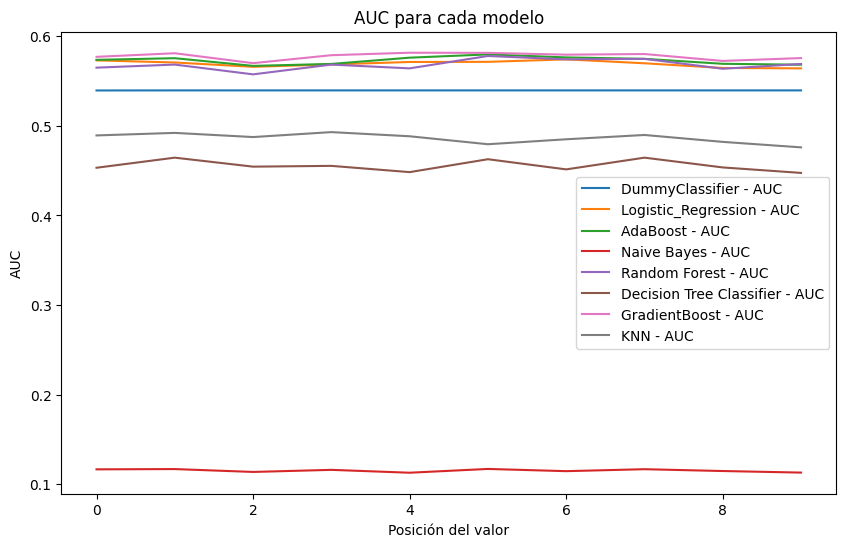

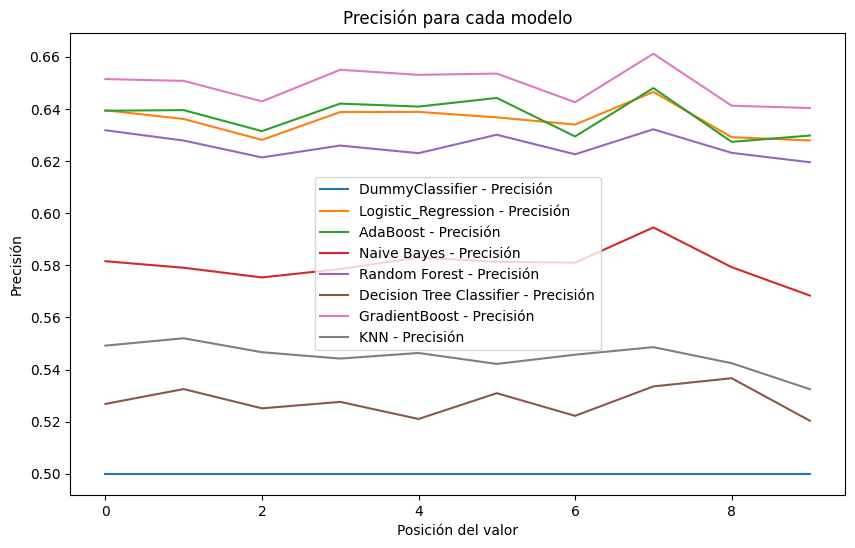

In [ ]:
# Datos de AUC y precisión para todos los modelos
resultado_1 = [
    ['DummyClassifier', [0.5395924308588064, 0.5396709855874218, 0.5396709855874218, 0.5396709855874218, 0.5396709855874218, 0.5396709855874218, 0.5396709855874218, 0.5396709855874218, 0.5396709855874218, 0.5396709855874218], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]],
    ['Logistic_Regression', [0.573216885007278, 0.5708254476634154, 0.566021254913379, 0.5686417236861261, 0.5714077740573591, 0.5715533556558451, 0.5743194060270782, 0.5699519580724997, 0.5647110205270054, 0.5642742757315475], [0.6394963225985206, 0.6361606760929587, 0.6281335263748178, 0.6388100644759119, 0.6388795443893033, 0.6367815311644645, 0.6339974451789243, 0.646546494422355, 0.6291595268172091, 0.6279208518067786]],
    ['AdaBoost', [0.5737991266375546, 0.5756296404134518, 0.5670403261027807, 0.5692240500800699, 0.5762119668073955, 0.5798515067695443, 0.5765031300043675, 0.5749017324210219, 0.5693696316785558, 0.5683505604891542], [0.6393273602697516, 0.6395593992981361, 0.6314914166565044, 0.6420620260719035, 0.6409117202192974, 0.6442308482362465, 0.629446148433767, 0.6480221742757808, 0.6273778605682442, 0.6297967525451812]],
    ['Naive Bayes', [0.11644832605531295, 0.116756441985733, 0.11355364681904208, 0.1158829523948173, 0.11268015722812637, 0.11690202358421896, 0.11442713640995777, 0.11661086038724705, 0.11457271800844374, 0.11282573882661232], [0.5815621978138368, 0.5790573743461316, 0.5753389053853957, 0.5785722849211994, 0.5830004894066282, 0.581342181078388, 0.5810067126299804, 0.5945194608475983, 0.5792812838856092, 0.5683714646857414]],
    ['Random Forest', [0.5650655021834061, 0.5684961420876401, 0.5575775222011937, 0.5684961420876401, 0.5642742757315475, 0.5781045275877129, 0.5743194060270782, 0.5749017324210219, 0.5638375309360897, 0.5692240500800699], [0.6318250191508171, 0.6278776273874658, 0.6214031307227992, 0.6259587317736476, 0.6230294513494739, 0.6301099021455399, 0.6226028618248103, 0.6321914045547539, 0.6231502392629209, 0.6195447893819485]],
    ['Decision Tree Classifier', [0.45327510917030567, 0.46455088076867085, 0.4545057504731402, 0.4553792400640559, 0.44839132333673026, 0.46280390158683943, 0.4514485369049352, 0.46455088076867085, 0.45363226088222447, 0.44751783374581455], [0.5267930229947216, 0.5324984060112359, 0.5250941441692812, 0.5275712947885375, 0.5210060107353355, 0.5309086126605677, 0.5222182928105398, 0.5335159602534308, 0.5366565662869991, 0.5203229372799761]],
    ['GradientBoost', [0.5771470160116449, 0.5811617411559179, 0.5700975396709856, 0.5789780171786286, 0.5817440675498617, 0.5815984859513758, 0.5795603435725725, 0.5802882515650022, 0.5725724268452468, 0.5757752220119376], [0.6514685228033708, 0.6507724386087055, 0.642913506235799, 0.6550341019545477, 0.6530973031645582, 0.6535790786965051, 0.6425795381362648, 0.6612029773921301, 0.6412578273149501, 0.6403500823585778]],
    ['KNN', [0.4893740902474527, 0.4922113844810016, 0.4875527733294512, 0.4930848740719173, 0.48842626292036684, 0.47954578541272386, 0.48507788615519, 0.4898820789052264, 0.48216625418547093, 0.476051827049061], [0.5491711640133109, 0.5519855782867074, 0.5466296027655543, 0.5441973281909028, 0.5463392351408961, 0.5421471203870136, 0.5456804687051409, 0.5485790779218572, 0.542426658038202, 0.5324420509306841]]
]


# Extraer las listas de AUC y precisión
auc_scores = [model[1] for model in resultado_1]
precision_scores = [model[2] for model in resultado_1]
model_names = [model[0] for model in resultado_1]

# Graficar AUC
plt.figure(figsize=(10, 6))
for i, model_auc in enumerate(auc_scores):
    plt.plot(range(len(model_auc)), model_auc, label=f'{model_names[i]} - AUC')

plt.xlabel('Posición del valor')
plt.ylabel('AUC')
plt.title('AUC para cada modelo')
plt.legend()
plt.show()

# Graficar Precisión
plt.figure(figsize=(10, 6))
for i, model_precision in enumerate(precision_scores):
    plt.plot(range(len(model_precision)), model_precision, label=f'{model_names[i]} - Precisión')

plt.xlabel('Posición del valor')
plt.ylabel('Precisión')
plt.title('Precisión para cada modelo')
plt.legend()
plt.show()


Mismo codigo despues de eliminar las variables

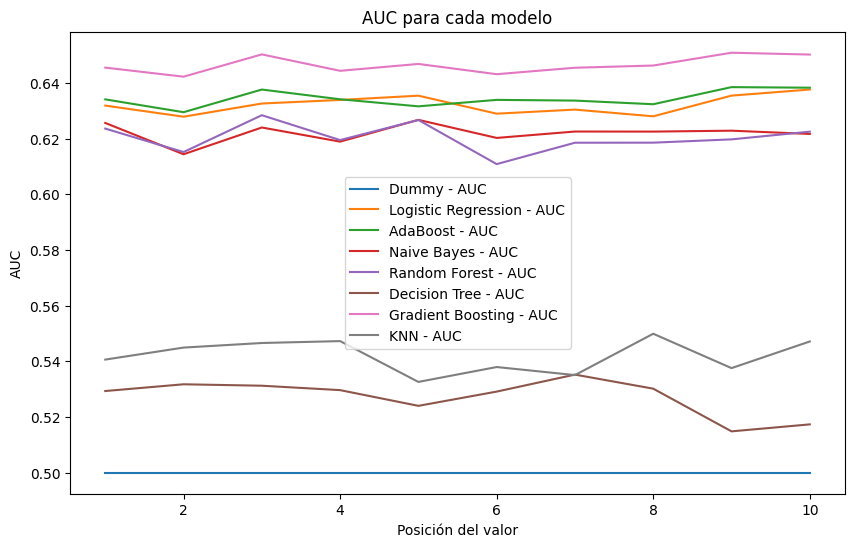

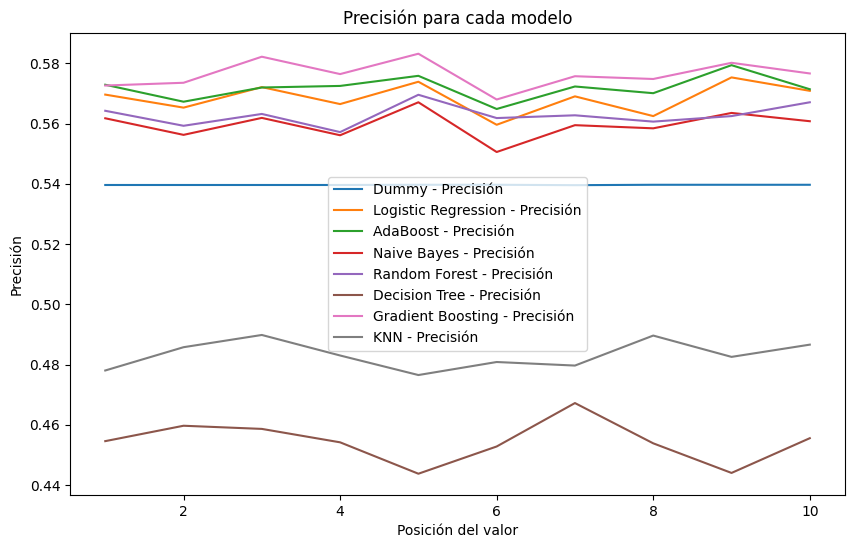

In [ ]:
import matplotlib.pyplot as plt

# Extraer los nombres de los modelos
model_names = list(df_auc_results.columns)

# Graficar AUC
plt.figure(figsize=(10, 6))
for model_name in model_names:
    plt.plot(range(1, 11), df_auc_results.loc[:, model_name], label=f'{model_name} - AUC')

plt.xlabel('Posición del valor')
plt.ylabel('AUC')
plt.title('AUC para cada modelo')
plt.legend()
plt.show()

# Graficar Precisión
plt.figure(figsize=(10, 6))
for model_name in model_names:
    plt.plot(range(1, 11), df_accuracy_results.loc[:, model_name], label=f'{model_name} - Precisión')

plt.xlabel('Posición del valor')
plt.ylabel('Precisión')
plt.title('Precisión para cada modelo')
plt.legend()
plt.show()


El resultado p-value nos indica si las distribuciones son o no distintas ya que examina dos colas. Pero si únicamente queremos saber si una es mejor que la otra tenemos el parámetro greater o less según comparemos si 'x' > 'y', o 'x' <'y', respectivamente.

En este caso como el p-value es 0.01 < 0.05, rechazamos la hipótesis nula y determinamos que 'x' es mayor que 'y' con una confianza mayor del 95%

In [ ]:
warnings.filterwarnings("ignore")

print('DummyClassifier y regresión logistica')
# Extraer los datos de AUC y precisión para cada modelo
auc_scores = [modelo[1] for modelo in resultado_1]
precision_scores = [modelo[2] for modelo in resultado_1]

# Realizar el test de Wilcoxon
wilcox_V_auc, p_value_auc = wilcoxon(auc_scores[0], auc_scores[1], alternative='greater', zero_method='wilcox', correction=False)
wilcox_V_precision, p_value_precision = wilcoxon(precision_scores[0], precision_scores[1], alternative='greater', zero_method='wilcox', correction=False)

# Imprimir resultados
print('Resultados completos del test de Wilcoxon para AUC:')
print(f'Wilcox V: {wilcox_V_auc}, p-value: {p_value_auc:.2f}')

print('\nResultados completos del test de Wilcoxon para precisión:')
print(f'Wilcox V: {wilcox_V_precision}, p-value: {p_value_precision:.2f}')

print('\nAdaboost y regresión logistica')
# Extraer los datos de AUC y precisión para cada modelo
auc_scores = [modelo[1] for modelo in resultado_1]
precision_scores = [modelo[2] for modelo in resultado_1]

# Realizar el test de Wilcoxon
wilcox_V_auc, p_value_auc = wilcoxon(auc_scores[2], auc_scores[1], alternative='greater', zero_method='wilcox', correction=False)
wilcox_V_precision, p_value_precision = wilcoxon(precision_scores[2], precision_scores[1], alternative='greater', zero_method='wilcox', correction=False)

# Imprimir resultados
print('Resultados completos del test de Wilcoxon para AUC:')
print(f'Wilcox V: {wilcox_V_auc}, p-value: {p_value_auc:.2f}')

print('\nResultados completos del test de Wilcoxon para precisión:')
print(f'Wilcox V: {wilcox_V_precision}, p-value: {p_value_precision:.2f}')

print('\nRandom Forest y regresión logistica')
# Extraer los datos de AUC y precisión para cada modelo
auc_scores = [modelo[1] for modelo in resultado_1]
precision_scores = [modelo[2] for modelo in resultado_1]

# Realizar el test de Wilcoxon
wilcox_V_auc, p_value_auc = wilcoxon(auc_scores[4], auc_scores[1], alternative='greater', zero_method='wilcox', correction=False)
wilcox_V_precision, p_value_precision = wilcoxon(precision_scores[4], precision_scores[1], alternative='greater', zero_method='wilcox', correction=False)

# Imprimir resultados
print('Resultados completos del test de Wilcoxon para AUC:')
print(f'Wilcox V: {wilcox_V_auc}, p-value: {p_value_auc:.2f}')

print('\nResultados completos del test de Wilcoxon para precisión:')
print(f'Wilcox V: {wilcox_V_precision}, p-value: {p_value_precision:.2f}')

print('\nRandom Forest y Gradient Boost')
# Extraer los datos de AUC y precisión para cada modelo
auc_scores = [modelo[1] for modelo in resultado_1]
precision_scores = [modelo[2] for modelo in resultado_1]

# Realizar el test de Wilcoxon
wilcox_V_auc, p_value_auc = wilcoxon(auc_scores[4], auc_scores[6], alternative='greater', zero_method='wilcox', correction=False)
wilcox_V_precision, p_value_precision = wilcoxon(precision_scores[6], precision_scores[1], alternative='greater', zero_method='wilcox', correction=False)

# Imprimir resultados
print('Resultados completos del test de Wilcoxon para AUC:')
print(f'Wilcox V: {wilcox_V_auc}, p-value: {p_value_auc:.2f}')

print('\nResultados completos del test de Wilcoxon para precisión:')
print(f'Wilcox V: {wilcox_V_precision}, p-value: {p_value_precision:.2f}')

print('\nGradient Boost y regresión logistica')
# Extraer los datos de AUC y precisión para cada modelo
auc_scores = [modelo[1] for modelo in resultado_1]
precision_scores = [modelo[2] for modelo in resultado_1]

# Realizar el test de Wilcoxon
wilcox_V_auc, p_value_auc = wilcoxon(auc_scores[6], auc_scores[1], alternative='greater', zero_method='wilcox', correction=False)
wilcox_V_precision, p_value_precision = wilcoxon(precision_scores[6], precision_scores[1], alternative='greater', zero_method='wilcox', correction=False)

# Imprimir resultados
print('Resultados completos del test de Wilcoxon para AUC:')
print(f'Wilcox V: {wilcox_V_auc}, p-value: {p_value_auc:.2f}')

print('\nResultados completos del test de Wilcoxon para precisión:')
print(f'Wilcox V: {wilcox_V_precision}, p-value: {p_value_precision:.2f}')

DummyClassifier y regresión logistica
Resultados completos del test de Wilcoxon para AUC:
Wilcox V: 0.0, p-value: 1.00

Resultados completos del test de Wilcoxon para precisión:
Wilcox V: 0.0, p-value: 1.00

Adaboost y regresión logistica
Resultados completos del test de Wilcoxon para AUC:
Wilcox V: 55.0, p-value: 0.00

Resultados completos del test de Wilcoxon para precisión:
Wilcox V: 42.0, p-value: 0.08

Random Forest y regresión logistica
Resultados completos del test de Wilcoxon para AUC:
Wilcox V: 15.0, p-value: 0.81

Resultados completos del test de Wilcoxon para precisión:
Wilcox V: 0.0, p-value: 1.00

Random Forest y Gradient Boost
Resultados completos del test de Wilcoxon para AUC:
Wilcox V: 0.0, p-value: 1.00

Resultados completos del test de Wilcoxon para precisión:
Wilcox V: 55.0, p-value: 0.00

Gradient Boost y regresión logistica
Resultados completos del test de Wilcoxon para AUC:
Wilcox V: 55.0, p-value: 0.00

Resultados completos del test de Wilcoxon para precisión:
Wi

adaboost gradient boost regresion logistica y random forest

In [ ]:
import pandas as pd
from scipy.stats import wilcoxon

print("Resultados del test de Wilcoxon")
print("--------------------------------")

# Obtener los nombres de los modelos
model_names = list(df_auc_results.columns)

# Crear un DataFrame para almacenar los resultados del test de Wilcoxon
tabla_resultados = pd.DataFrame(index=model_names, columns=model_names)

for model_name_x in model_names:
    for model_name_y in model_names:
        if model_name_x != model_name_y:
            _, p_value = wilcoxon(df_auc_results[model_name_x], df_auc_results[model_name_y], alternative='greater', zero_method='wilcox', correction=False)
            if p_value < 0.05:
                tabla_resultados.loc[model_name_x, model_name_y] = '\u2714'
            else:
                tabla_resultados.loc[model_name_x, model_name_y] = 'x'
        else:
            tabla_resultados.loc[model_name_x, model_name_y] = "-"

print(tabla_resultados)


Resultados del test de Wilcoxon
--------------------------------
                    Dummy Logistic Regression AdaBoost Naive Bayes  \
Dummy                   -                   x        x           x   
Logistic Regression     ✔                   -        x           ✔   
AdaBoost                ✔                   ✔        -           ✔   
Naive Bayes             ✔                   x        x           -   
Random Forest           ✔                   x        x           x   
Decision Tree           ✔                   x        x           x   
Gradient Boosting       ✔                   ✔        ✔           ✔   
KNN                     ✔                   x        x           x   

                    Random Forest Decision Tree Gradient Boosting KNN  
Dummy                           x             x                 x   x  
Logistic Regression             ✔             ✔                 x   ✔  
AdaBoost                        ✔             ✔                 x   ✔  
Naive Bayes     

# Oversampling y undersampling

Este codigo no está correcto ya que se hace oversampling y undersampling de todas las muestras

In [ ]:

# Define the oversampler and undersampler
oversampler = RandomOverSampler()
undersampler = RandomUnderSampler()

# Initialize lists to store results
columns_names = list(classifiers.keys())
rows_data = []

# Function to evaluate model with oversampling or undersampling
def evaluate_model_with_sampling(model, data_train, target_train, sampler):
    data_resampled, target_resampled = sampler.fit_resample(data_train, target_train)
    accuracy_scores = cross_val_score(model, data_resampled, target_resampled, cv=5, scoring='accuracy')
    target_predicted_proba = cross_val_predict(model, data_resampled, target_resampled, cv=5, method='predict_proba')
    target_binarized = label_binarize(target_resampled, classes=np.unique(target_resampled))
    auc_scores = roc_auc_score(target_binarized, target_predicted_proba, average='macro')
    return accuracy_scores, auc_scores

# Evaluate models with oversampling and undersampling
for name, model in classifiers.items():
    accuracy_scores_over, auc_scores_over = evaluate_model_with_sampling(model, data_train, target_train, oversampler)
    accuracy_scores_under, auc_scores_under = evaluate_model_with_sampling(model, data_train, target_train, undersampler)

    row_data_over = [accuracy_scores_over.mean(), auc_scores_over.mean()]  # Scores with oversampling
    row_data_under = [accuracy_scores_under.mean(), auc_scores_under.mean()]  # Scores with undersampling

    rows_data.append(row_data_over + row_data_under)  # Append both sets of scores

    print(f"Model: {name}")
    print(f"Mean Accuracy (Oversampling): {accuracy_scores_over.mean():.4f}")
    print(f"Mean AUC (Oversampling): {auc_scores_over.mean():.4f}")
    print(f"Mean Accuracy (Undersampling): {accuracy_scores_under.mean():.4f}")
    print(f"Mean AUC (Undersampling): {auc_scores_under.mean():.4f}")
    print()

# Create the DataFrame of cross-validation results
df_cross_validation = pd.DataFrame(rows_data, columns=["Mean Accuracy (Oversampling)", "Mean AUC (Oversampling)",
                                                       "Mean Accuracy (Undersampling)", "Mean AUC (Undersampling)"],
                                    index=columns_names)

print(df_cross_validation)


Model: Dummy
Mean Accuracy (Oversampling): 0.3333
Mean AUC (Oversampling): 0.5000
Mean Accuracy (Undersampling): 0.3333
Mean AUC (Undersampling): 0.4999

Model: Logistic Regression
Mean Accuracy (Oversampling): 0.4323
Mean AUC (Oversampling): 0.6172
Mean Accuracy (Undersampling): 0.4264
Mean AUC (Undersampling): 0.6125

Model: AdaBoost
Mean Accuracy (Oversampling): 0.4401
Mean AUC (Oversampling): 0.6232
Mean Accuracy (Undersampling): 0.4335
Mean AUC (Undersampling): 0.6161

Model: Naive Bayes
Mean Accuracy (Oversampling): 0.4139
Mean AUC (Oversampling): 0.6096
Mean Accuracy (Undersampling): 0.4104
Mean AUC (Undersampling): 0.6071

Model: Random Forest
Mean Accuracy (Oversampling): 0.8266
Mean AUC (Oversampling): 0.9471
Mean Accuracy (Undersampling): 0.4164
Mean AUC (Undersampling): 0.6003

Model: Decision Tree
Mean Accuracy (Oversampling): 0.7643
Mean AUC (Oversampling): 0.8225
Mean Accuracy (Undersampling): 0.3682
Mean AUC (Undersampling): 0.5267

Model: Gradient Boosting
Mean Accurac

In [ ]:
# Iterate over classifiers
for name, clf in classifiers.items():
    print(f"Classifier: {name}")

    # Apply oversampling
    ros = RandomOverSampler()
    X_train_resampled, y_train_resampled = ros.fit_resample(data_train, target_train)

    # Train the classifier with oversampled data
    clf.fit(X_train_resampled, y_train_resampled)

    # Make predictions with oversampled data
    y_pred_oversampled = clf.predict(data_test)

    # Calculate accuracy with oversampled data
    accuracy_oversampled = accuracy_score(target_test, y_pred_oversampled)
    print("Results with Oversampling:")
    print(f"Accuracy: {accuracy_oversampled:.4f}")

    # Calculate precision with oversampled data
    precision_oversampled = precision_score(target_test, y_pred_oversampled, average='weighted')
    print(f"Precision: {precision_oversampled:.4f}")

    # Calculate AUC with oversampled data
    y_test_bin = label_binarize(target_test, classes=clf.classes_)
    if len(clf.classes_) == 2:
        auc_oversampled = roc_auc_score(y_test_bin, clf.predict_proba(data_test)[:, 1])
    else:
        auc_oversampled = roc_auc_score(y_test_bin, clf.predict_proba(data_test), average='macro', multi_class='ovr')
    print(f"AUC: {auc_oversampled:.4f}")
    print()

    # Apply undersampling
    rus = RandomUnderSampler()
    X_train_resampled, y_train_resampled = rus.fit_resample(data_train, target_train)

    # Train the classifier with undersampled data
    clf.fit(X_train_resampled, y_train_resampled)

    # Make predictions with undersampled data
    y_pred_undersampled = clf.predict(data_test)

    # Calculate accuracy with undersampled data
    accuracy_undersampled = accuracy_score(target_test, y_pred_undersampled)
    print("Results with Undersampling:")
    print(f"Accuracy: {accuracy_undersampled:.4f}")

    # Calculate precision with undersampled data
    precision_undersampled = precision_score(target_test, y_pred_undersampled, average='weighted')
    print(f"Precision: {precision_undersampled:.4f}")

    # Calculate AUC with undersampled data
    if len(clf.classes_) == 2:
        auc_undersampled = roc_auc_score(y_test_bin, clf.predict_proba(data_test)[:, 1])
    else:
        auc_undersampled = roc_auc_score(y_test_bin, clf.predict_proba(data_test), average='macro', multi_class='ovr')
    print(f"AUC: {auc_undersampled:.4f}")
    print()

# Cálculo de pesos

## Modelo lineal

In [ ]:
# Paso 4: Obtención de los coeficientes del modelo de regresión logística
logistic_regression_model = logistic_regression[-1]  # Obtenemos el último estimador (regresión logística) del pipeline
coefs = logistic_regression_model.coef_[0]  # Obtenemos los coeficientes del modelo

# Convertir los coeficientes en una Serie de pandas con los nombres de las características como índices
weights = pd.Series(coefs, index=data.columns)

print("Pesos de las características:")
print(weights)

## Adaboost

In [ ]:
# Obtener los pesos de los estimadores base utilizados internamente por el clasificador AdaBoost
base_estimator_weights = np.array(adaboost_classifier.estimator_weights_)

print("Pesos de los estimadores base para AdaBoost:")
print(base_estimator_weights)

## Random Forest

In [ ]:
# Obtener los pesos de las características
feature_importances = rf_classifier.feature_importances_

# Convertir los pesos de las características en un DataFrame de pandas con los nombres de las características
feature_importance_df = pd.DataFrame({'Feature': data.columns, 'Importance': feature_importances})

print("Pesos de las características:")
print(feature_importance_df)

# Features

## Selección de características basada en modelos

Algunos algoritmos de aprendizaje automático, como los árboles de decisión y las máquinas de vectores de soporte (SVM), proporcionan importancias de características incorporadas que se pueden utilizar para seleccionar las características más relevantes.

In [ ]:

classifiers = {
    "Dummy": DummyClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=5000, penalty=None),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier()
}

columns_names = list(classifiers.keys())
rows_data = []

# Entrenar un árbol de decisión para obtener importancias de características
tree_classifier = DecisionTreeClassifier()
tree_classifier.fit(data_train, target_train)

# Crear un selector de características basado en la importancia del árbol de decisión
selector_tree = SelectFromModel(tree_classifier, prefit=True)

# Transformar los datos de entrenamiento y prueba
data_train_selected_tree = selector_tree.transform(data_train)
data_test_selected_tree = selector_tree.transform(data_test)

# Entrenar el modelo con las características seleccionadas mediante árboles de decisión
selected_classifiers_tree = {name: clone(model).fit(data_train_selected_tree, target_train) for name, model in classifiers.items()}

# Evaluar los modelos con las características seleccionadas mediante árboles de decisión
rows_data_selected_tree = []
for name, model in selected_classifiers_tree.items():
    target_pred = model.predict(data_test_selected_tree)
    accuracy = accuracy_score(target_test, target_pred)
    lb = LabelBinarizer()
    target_test_bin = lb.fit_transform(target_test)
    target_pred_bin = lb.transform(target_pred)
    auc = roc_auc_score(target_test_bin, target_pred_bin, average='macro')
    row_data = [accuracy, auc]
    rows_data_selected_tree.append(row_data)
    print(f"Model: {name}")
    print(f"Accuracy with selected features (Decision Trees): {accuracy:.4f}")
    print(f"AUC with selected features (Decision Trees): {auc:.4f}")
    print()

# Creamos el DataFrame de la evaluación con características seleccionadas mediante árboles de decisión
df_evaluation_selected_tree = pd.DataFrame(rows_data_selected_tree, columns=["Accuracy (Selected)", "AUC (Selected)"], index=columns_names)

print(df_evaluation_selected_tree)

## Selección de características mediante regularización

Algunos modelos, como la regresión logística con regularización L1 (Lasso), penalizan automáticamente las características menos importantes, lo que puede llevar a la selección automática de características.

In [ ]:
classifiers = {
    "Dummy": DummyClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=5000, penalty=None),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier()
}

columns_names = list(classifiers.keys())
rows_data = []
from sklearn.linear_model import LogisticRegression

# Entrenar un modelo de regresión logística con regularización L1 (Lasso)
logistic_regression = LogisticRegression(penalty='l1', solver='liblinear')
logistic_regression.fit(data_train, target_train)

# Crear un selector de características basado en los coeficientes del modelo
selector_lasso = SelectFromModel(logistic_regression, prefit=True)

# Transformar los datos de entrenamiento y prueba
data_train_selected_lasso = selector_lasso.transform(data_train)
data_test_selected_lasso = selector_lasso.transform(data_test)

# Entrenar el modelo con las características seleccionadas mediante regularización L1
selected_classifiers_lasso = {name: clone(model).fit(data_train_selected_lasso, target_train) for name, model in classifiers.items()}

# Evaluar los modelos con las características seleccionadas mediante regularización L1
rows_data_selected_lasso = []
for name, model in selected_classifiers_lasso.items():
    target_pred = model.predict(data_test_selected_lasso)
    accuracy = accuracy_score(target_test, target_pred)
    lb = LabelBinarizer()
    target_test_bin = lb.fit_transform(target_test)
    target_pred_bin = lb.transform(target_pred)
    auc = roc_auc_score(target_test_bin, target_pred_bin, average='macro')
    row_data = [accuracy, auc]
    rows_data_selected_lasso.append(row_data)
    print(f"Model: {name}")
    print(f"Accuracy with selected features (Lasso Regularization): {accuracy:.4f}")
    print(f"AUC with selected features (Lasso Regularization): {auc:.4f}")
    print()

# Creamos el DataFrame de la evaluación con características seleccionadas mediante regularización L1
df_evaluation_selected_lasso = pd.DataFrame(rows_data_selected_lasso, columns=["Accuracy (Selected)", "AUC (Selected)"], index=columns_names)

print(df_evaluation_selected_lasso)


## Selección de características utilizando técnicas de embedding

Estas técnicas aprenden automáticamente las características más relevantes durante el entrenamiento del modelo. Ejemplos incluyen métodos de reducción de dimensionalidad como PCA (Análisis de Componentes Principales) y métodos de selección de características basados en modelos como L1 regularization en modelos lineales.

In [ ]:


classifiers = {
    "Dummy": DummyClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=5000, penalty=None),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier()
}

columns_names = list(classifiers.keys())
rows_data = []
# Aplicar PCA para reducción de dimensionalidad y selección de características
pca = PCA(n_components=10)  # Selecciona las 10 mejores componentes principales
data_train_selected_pca = pca.fit_transform(data_train)
data_test_selected_pca = pca.transform(data_test)

# Entrenar el modelo con las características seleccionadas mediante PCA
selected_classifiers_pca = {name: clone(model).fit(data_train_selected_pca, target_train) for name, model in classifiers.items()}

# Evaluar los modelos con las características seleccionadas mediante PCA
rows_data_selected_pca = []
for name, model in selected_classifiers_pca.items():
    target_pred = model.predict(data_test_selected_pca)
    accuracy = accuracy_score(target_test, target_pred)
    lb = LabelBinarizer()
    target_test_bin = lb.fit_transform(target_test)
    target_pred_bin = lb.transform(target_pred)
    auc = roc_auc_score(target_test_bin, target_pred_bin, average='macro')
    row_data = [accuracy, auc]
    rows_data_selected_pca.append(row_data)
    print(f"Model: {name}")
    print(f"Accuracy with selected features (PCA): {accuracy:.4f}")
    print(f"AUC with selected features (PCA): {auc:.4f}")
    print()

# Creamos el DataFrame de la evaluación con características seleccionadas mediante PCA
df_evaluation_selected_pca = pd.DataFrame(rows_data_selected_pca, columns=["Accuracy (Selected)", "AUC (Selected)"], index=columns_names)

print(df_evaluation_selected_pca)

## Selección de características mediante técnicas de empaquetado

Estas técnicas evalúan diferentes subconjuntos de características utilizando un algoritmo de aprendizaje automático y seleccionan aquellos subconjuntos que producen los mejores resultados. Ejemplos incluyen la eliminación recursiva de características (RFE) y los algoritmos genéticos.

In [ ]:

classifiers = {
    "Dummy": DummyClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=5000, penalty=None),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier()
}

columns_names = list(classifiers.keys())
rows_data = []

logistic_regression = LogisticRegression(max_iter=5000, penalty=None)
rfe = RFE(estimator=logistic_regression, n_features_to_select=10)  # Selecciona las 10 mejores características
rfe.fit(data_train, target_train)
selected_features = rfe.support_
data_train_selected = data_train.iloc[:, selected_features]
data_test_selected = data_test.iloc[:, selected_features]

# Entrenar los modelos con las características seleccionadas
selected_classifiers = {name: clone(model).fit(data_train_selected, target_train) for name, model in classifiers.items()}

# Evaluar los modelos con las características seleccionadas
rows_data_selected = []
for name, model in selected_classifiers.items():
    # Predecir las etiquetas en los datos de prueba
    target_pred = model.predict(data_test_selected)
    # Calcular la precisión
    accuracy = accuracy_score(target_test, target_pred)
    # Calcular el AUC multiclase
    lb = LabelBinarizer()
    target_test_bin = lb.fit_transform(target_test)
    target_pred_bin = lb.transform(target_pred)
    auc = roc_auc_score(target_test_bin, target_pred_bin, average='macro')
    row_data = [accuracy, auc]
    rows_data_selected.append(row_data)
    print(f"Model: {name}")
    print(f"Accuracy with selected features: {accuracy:.4f}")
    print(f"AUC with selected features: {auc:.4f}")
    print()

# Creamos el DataFrame de la evaluación con características seleccionadas
df_evaluation_selected = pd.DataFrame(rows_data_selected, columns=["Accuracy (Selected)", "AUC (Selected)"], index=columns_names)

print(df_evaluation_selected)

## Selección de características utilizando métodos de agrupamiento

Estos métodos agrupan características similares y seleccionan un representante de cada grupo como características finales.

In [ ]:

classifiers = {
    "Dummy": DummyClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=5000, penalty=None),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier()
}

columns_names = list(classifiers.keys())
rows_data = []

# Aplicar KMeans para agrupar características
kmeans = KMeans(n_clusters=37)  # Selecciona 10 clusters
kmeans.fit(data_train.T)  # Transponemos los datos para que cada muestra sea una característica

# Obtener los centros de los clusters
cluster_centers = kmeans.cluster_centers_
# Ajustar la forma de los datos de entrenamiento y los centros de los clusters
data_train_reshaped = data_train.values.reshape(data_train.shape[0], 1, data_train.shape[1])
cluster_centers_reshaped = cluster_centers[:, None, :]

# Transponer el primer eje de los datos de entrenamiento
data_train_reshaped = np.transpose(data_train_reshaped, (2, 1, 0))

# Calcular la distancia entre los datos de entrenamiento y los centros de los clusters
distances = np.linalg.norm(data_train_reshaped - cluster_centers_reshaped, axis=2)

# Obtener los índices de las características más cercanas a los centros de los clusters
sorted_indices = np.argsort(distances)

# Seleccionar las características más cercanas a los centros de los clusters
selected_indices = sorted_indices[:, :10]

# Seleccionar las características en los datos de entrenamiento y prueba
data_train_selected_kmeans = data_train.iloc[:, selected_indices.flatten()]
data_test_selected_kmeans = data_test.iloc[:, selected_indices.flatten()]


# Entrenar y evaluar los modelos con las características seleccionadas mediante KMeans...
selected_classifiers_kmeans = {name: clone(model).fit(data_train_selected_kmeans, target_train) for name, model in classifiers.items()}

# Evaluar los modelos con las características seleccionadas mediante KMeans
rows_data_selected_kmeans = []
for name, model in selected_classifiers_kmeans.items():
    target_pred = model.predict(data_test_selected_kmeans)
    accuracy = accuracy_score(target_test, target_pred)
    lb = LabelBinarizer()
    target_test_bin = lb.fit_transform(target_test)
    target_pred_bin = lb.transform(target_pred)
    auc = roc_auc_score(target_test_bin, target_pred_bin, average='macro')
    row_data = [accuracy, auc]
    rows_data_selected_kmeans.append(row_data)
    print(f"Model: {name}")
    print(f"Accuracy with selected features (KMeans): {accuracy:.4f}")
    print(f"AUC with selected features (KMeans): {auc:.4f}")
    print()

# Creamos el DataFrame de la evaluación con características seleccionadas mediante KMeans
df_evaluation_selected_kmeans = pd.DataFrame(rows_data_selected_kmeans, columns=["Accuracy (Selected)", "AUC (Selected)"], index=columns_names)

print(df_evaluation_selected_kmeans)



## Selección de características basada en la información mutua

La información mutua entre dos variables mide la dependencia entre ellas y puede ser utilizada para seleccionar características relevantes para la variable objetivo

In [ ]:
columns_names = list(classifiers.keys())
rows_data = []

# Aplicar la información mutua para seleccionar características
selector_mi = SelectKBest(score_func=mutual_info_classif, k=10)  # Selecciona las 10 mejores características
data_train_mi = selector_mi.fit_transform(data_train, target_train)
data_test_mi = selector_mi.transform(data_test)

# Entrenar los modelos con las características seleccionadas mediante información mutua
selected_classifiers_mi = {name: clone(model).fit(data_train_mi, target_train) for name, model in classifiers.items()}

# Evaluar los modelos con las características seleccionadas mediante información mutua
rows_data_selected_mi = []
for name, model in selected_classifiers_mi.items():
    target_pred = model.predict(data_test_mi)
    accuracy = accuracy_score(target_test, target_pred)
    lb = LabelBinarizer()
    target_test_bin = lb.fit_transform(target_test)
    target_pred_bin = lb.transform(target_pred)
    auc = roc_auc_score(target_test_bin, target_pred_bin, average='macro')
    row_data = [accuracy, auc]
    rows_data_selected_mi.append(row_data)
    print(f"Model: {name}")
    print(f"Accuracy with selected features (Mutual Information): {accuracy:.4f}")
    print(f"AUC with selected features (Mutual Information): {auc:.4f}")
    print()

# Creamos el DataFrame de la evaluación con características seleccionadas mediante información mutua
df_evaluation_selected_mi = pd.DataFrame(rows_data_selected_mi, columns=["Accuracy (Selected)", "AUC (Selected)"], index=columns_names)

# SHAP y LIME

## Regresión Logistica

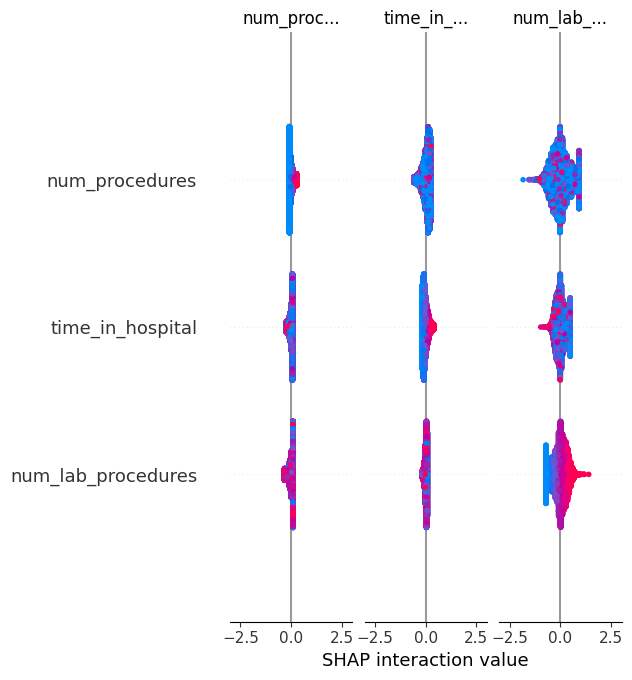

In [ ]:

logistic_model = logistic_regression.named_steps['logisticregression']

# Crear un objeto explainer de SHAP con el modelo entrenado
explainer = shap.Explainer(logistic_model, data_train)

# Calcular los valores SHAP para el conjunto de prueba
shap_values = explainer(data_test)

shap.summary_plot(shap_values, data_test, feature_names=data_test.columns)

In [ ]:

# Crear un objeto explainer de Lime para datos tabulares
explainer_lime = lime.lime_tabular.LimeTabularExplainer(data_train.values,
                                                        feature_names=data_train.columns)

# Explicar una instancia específica utilizando el modelo de regresión logística
lime_explanation = explainer_lime.explain_instance(data_test.iloc[0].values,
                                                   logistic_regression.predict_proba,
                                                   num_features=len(data_train.columns))

# Mostrar la explicación en un cuaderno (si estás utilizando Jupyter Notebook)
lime_explanation.show_in_notebook()

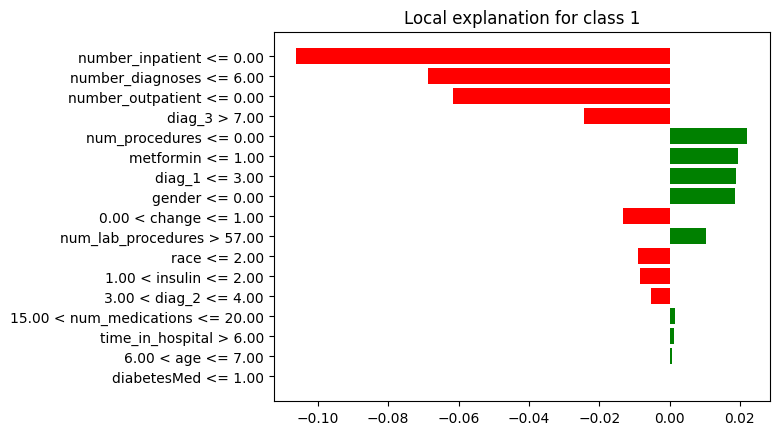

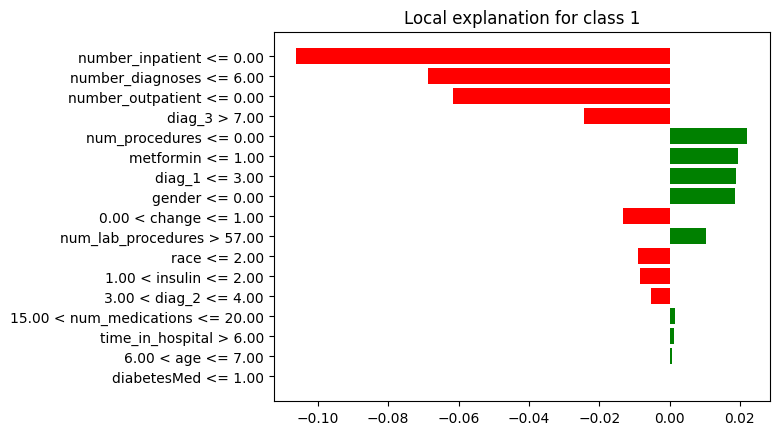

In [ ]:
# Mostrar la explicación en forma de gráfico de barras
lime_explanation.as_pyplot_figure()

In [ ]:
data_test.iloc[15].values


array([ 4, 40,  0, 28,  0,  1,  9,  2,  0,  5,  8,  5,  4,  2,  3,  0,  1])

In [ ]:
# Obtener la explicación para la clase específica (por ejemplo, la clase 1)
lime_explanation = explainer_lime.explain_instance(data_test.iloc[5].values,
                                                   logistic_regression.predict_proba,
                                                   num_features=len(data_train.columns),
                                                   labels=[1])

# Mostrar la explicación
lime_explanation.show_in_notebook()

## Gradient Boosting

In [ ]:
# Inicializar el clasificador Gradient Boosting
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Entrenar el clasificador
gb_classifier.fit(data_train, target_train)

# Realizar predicciones en el conjunto de prueba
y_pred = gb_classifier.predict(data_test)

y_proba = gb_classifier.predict_proba(data_test)
print("Resultados del clasificador con n_estimators = 100 y learning_rate = 0.1")
# Calcular la precisión
accuracy = accuracy_score(target_test, y_pred)
print("Precisión del clasificador Gradient Boosting: {:.4f}".format(accuracy))

auc_scores = roc_auc_score(target_test, y_proba, multi_class='ovr')
print("Roc AUC score: {:.4f}".format(auc_scores))


Resultados del clasificador con n_estimators = 100 y learning_rate = 0.1
Precisión del clasificador Gradient Boosting: 0.5747
Roc AUC score: 0.6460


In [ ]:
# Crear un objeto explainer de Lime para datos tabulares
explainer_lime = lime.lime_tabular.LimeTabularExplainer(data_train.values,
                                                        feature_names=data_train.columns)

# Explicar una instancia específica utilizando el modelo de AdaBoost
lime_explanation = explainer_lime.explain_instance(data_test.iloc[15].values,
                                                   adaboost_classifier.predict_proba,
                                                   num_features=len(data_train.columns))

# Mostrar la explicación en un cuaderno (si estás utilizando Jupyter Notebook)
lime_explanation.show_in_notebook()

# Técnicas para gradiente boosting

unir ambos modelos

In [ ]:
da_model = AdaBoostClassifier()
gb_model = GradientBoostingClassifier()

ada_model.fit(data_train, target_train)
gb_model.fit(data_train, target_train)

# Predicciones de los modelos base utilizando cross-validation
ada_pred = cross_val_predict(ada_model, data_train, target_train, cv=5, method='predict_proba')
gb_pred = cross_val_predict(gb_model, data_train, target_train, cv=5, method='predict_proba')

# Conjunto de entrenamiento para el meta-modelo
meta_train = np.column_stack((ada_pred[:, 1], gb_pred[:, 1]))

# Meta-modelo (Random Forest)
meta_model = RandomForestClassifier()

# Entrenar el meta-modelo
meta_model.fit(meta_train, target_train)

# Predecir con el ensemble
ada_pred_test = ada_model.predict_proba(data_test)
gb_pred_test = gb_model.predict_proba(data_test)
ensemble_pred_proba = (ada_pred_test + gb_pred_test) / 2  # Promedio de las probabilidades

# Convertir target_test a un formato binario
lb = LabelBinarizer()
target_test_binary = lb.fit_transform(target_test)

# Calcular el AUC para cada clase individualmente
auc_scores = []
for i in range(target_test_binary.shape[1]):
    auc_scores.append(roc_auc_score(target_test_binary[:, i], ensemble_pred_proba[:, i]))

# Calcular el promedio de los AUC
mean_auc = np.mean(auc_scores)

print("Mean AUC for Ensemble:", mean_auc)





Mean AUC for Ensemble: 0.6487270254466111


utilizar smote

In [ ]:
# Definir los modelos base
ada_model = AdaBoostClassifier()
gb_model = GradientBoostingClassifier()

ada_model.fit(data_train,target_train)
gb_model.fit(data_train,target_train)

# Aplicar SMOTE para el sobremuestreo de la clase minoritaria
smote = SMOTE(random_state=42)
data_train_resampled, target_train_resampled = smote.fit_resample(data_train, target_train)

# Entrenar los modelos base (AdaBoost y Gradient Boosting) con los datos resampleados
ada_model_resampled = AdaBoostClassifier()
ada_model_resampled.fit(data_train_resampled, target_train_resampled)

gb_model_resampled = GradientBoostingClassifier()
gb_model_resampled.fit(data_train_resampled, target_train_resampled)

# Evaluar los modelos base en los datos de prueba originales
ada_accuracy_resampled = ada_model_resampled.score(data_test, target_test)
gb_accuracy_resampled = gb_model_resampled.score(data_test, target_test)

print("AdaBoost Accuracy after SMOTE:", ada_accuracy_resampled)
print("Gradient Boosting Accuracy after SMOTE:", gb_accuracy_resampled)



AdaBoost Accuracy after SMOTE: 0.47755679584938293
Gradient Boosting Accuracy after SMOTE: 0.5003144406886251


In [ ]:
# Predecir probabilidades para los datos de prueba
ada_pred_proba_resampled = ada_model_resampled.predict_proba(data_test)
gb_pred_proba_resampled = gb_model_resampled.predict_proba(data_test)

# Calcular el AUC para cada clase individualmente
auc_scores_ada_resampled = []
auc_scores_gb_resampled = []

lb = LabelBinarizer()
target_test_binary = lb.fit_transform(target_test)

for i in range(target_test_binary.shape[1]):
    auc_scores_ada_resampled.append(roc_auc_score(target_test_binary[:, i], ada_pred_proba_resampled[:, i]))
    auc_scores_gb_resampled.append(roc_auc_score(target_test_binary[:, i], gb_pred_proba_resampled[:, i]))

# Calcular el promedio de los AUC
mean_auc_ada_resampled = np.mean(auc_scores_ada_resampled)
mean_auc_gb_resampled = np.mean(auc_scores_gb_resampled)

print("Mean AUC for AdaBoost after SMOTE:", mean_auc_ada_resampled)
print("Mean AUC for Gradient Boosting after SMOTE:", mean_auc_gb_resampled)

Mean AUC for AdaBoost after SMOTE: 0.5917052249194091
Mean AUC for Gradient Boosting after SMOTE: 0.6066825206861977


Para implementar técnicas de regularización en modelos como Gradient Boosting, podemos utilizar los parámetros específicos del modelo que controlan la complejidad y la penalización. Por ejemplo, en Gradient Boosting, podemos utilizar parámetros como max_depth para limitar la profundidad de los árboles base y learning_rate para reducir la contribución de cada árbol.

In [ ]:

# Crear el modelo de Gradient Boosting con regularización
gb_model_regularized = GradientBoostingClassifier(max_depth=6, learning_rate=0.1)  # Ejemplo de parámetros regularizados

# Entrenar el modelo
gb_model_regularized.fit(data_train, target_train)

# Predecir en los datos de prueba
target_pred = gb_model_regularized.predict(data_test)

# Calcular la precisión
accuracy = accuracy_score(target_test, target_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5755050703561041


In [ ]:

# Predecir probabilidades para cada clase utilizando el modelo
y_pred_proba = gb_model_regularized.predict_proba(data_test)

lb = LabelBinarizer()
target_test_binary = lb.fit_transform(target_test)
# Calcular el AUC para cada clase individualmente
auc_scores = []
for i in range(target_test_binary.shape[1]):
    auc_scores.append(roc_auc_score(target_test_binary[:, i], y_pred_proba[:, i]))

# Calcular el promedio de los AUC
mean_auc = np.mean(auc_scores)

print("Mean AUC:", mean_auc)

Mean AUC: 0.6514672886088945


# Seleccion de caracteristicas y reduccion de la dimensionalidad.
La selección de características y la reducción de la dimensionalidad son técnicas fundamentales en el preprocesamiento de datos y el desarrollo de modelos de aprendizaje automático.

En primer lugar, la **selección de características** desempeña un papel crucial al eliminar características que pueden ser irrelevantes o redundantes para el problema en cuestión. Al eliminar estas características, se mejora la calidad de los datos al eliminar el ruido y se reduce el riesgo de sobreajuste en los modelos. Además, la selección de características puede ayudar a reducir el costo computacional al eliminar las características menos informativas, lo que resulta en un tiempo de entrenamiento más rápido y una menor complejidad del modelo.

Por otro lado, la **reducción de la dimensionalidad** tiene como objetivo principal reducir el número de características manteniendo la mayor cantidad posible de información relevante. Esto es especialmente útil cuando se trabaja con conjuntos de datos de alta dimensionalidad, donde puede haber una gran cantidad de características que pueden no ser necesarias o incluso perjudiciales para el rendimiento del modelo. Al reducir la dimensionalidad, se puede eliminar el ruido y la redundancia, lo que conduce a modelos más simples y fáciles de interpretar.

Además, la reducción de la dimensionalidad también facilita la visualización de datos al proyectarlos en un espacio de menor dimensionalidad. Esto permite una comprensión más intuitiva de la estructura y las relaciones entre las muestras de datos, lo que puede ser útil para explorar y comprender mejor los datos antes de aplicar modelos de aprendizaje automático.


## Seleccion de caracteristicas con SelectKBest y reduccion de la dimensionalidad con PCA, principal Component Analisis

SelectKBest y PCA son técnicas utilizadas para seleccionar características relevantes y reducir la dimensionalidad de los datos en el aprendizaje automático. SelectKBest identifica las características más informativas utilizando pruebas estadísticas como la prueba chi-cuadrado, lo que mejora la eficiencia y la interpretabilidad del modelo al centrarse en las características más influyentes. Por otro lado, PCA transforma el conjunto de datos en un conjunto más compacto de componentes principales, capturando la mayor variabilidad posible en menos dimensiones y facilitando la interpretación de los datos. Ambas técnicas son herramientas valiosas para mejorar el rendimiento y la comprensión de los modelos de aprendizaje automático al abordar problemas de dimensionalidad y selección de características.

In [ ]:
# Escalar las características para que estén en el rango [0, 1]
scaler = MinMaxScaler()
data_train_scaled = scaler.fit_transform(data_train)
data_test_scaled = scaler.transform(data_test)

# Seleccionar las mejores características utilizando chi-cuadrado (puede variar según el tipo de problema)
selector = SelectKBest(score_func=chi2, k=2)
data_train_selected = selector.fit_transform(data_train_scaled, target_train)
data_test_selected = selector.transform(data_test_scaled)

# Reducir la dimensionalidad utilizando PCA
pca = PCA(n_components=2)
data_train_pca = pca.fit_transform(data_train_scaled)
data_test_pca = pca.transform(data_test_scaled)

# Entrenar un clasificador Gradient Boosting utilizando las características seleccionadas por SelectKBest
clf_kbest = GradientBoostingClassifier(random_state=42)
clf_kbest.fit(data_train_selected, target_train)
y_pred_kbest = clf_kbest.predict(data_test_selected)
accuracy_kbest = accuracy_score(target_test, y_pred_kbest)
auc_kbest = roc_auc_score(target_test, clf_kbest.predict_proba(data_test_selected), multi_class='ovr')
print("Accuracy using SelectKBest with Gradient Boosting:", accuracy_kbest)
print("AUC using SelectKBest with Gradient Boosting:", auc_kbest)

# Entrenar un clasificador Gradient Boosting utilizando las características reducidas por PCA
clf_pca = GradientBoostingClassifier(random_state=42)
clf_pca.fit(data_train_pca, target_train)
y_pred_pca = clf_pca.predict(data_test_pca)
accuracy_pca = accuracy_score(target_test, y_pred_pca)
auc_pca = roc_auc_score(target_test, clf_pca.predict_proba(data_test_pca), multi_class='ovr')
print("Accuracy using PCA with Gradient Boosting:", accuracy_pca)
print("AUC using PCA with Gradient Boosting:", auc_pca)



* SelectKBest - Espacio de Características Seleccionadas:

Cada punto en el gráfico representa una muestra del conjunto de datos.
Las dos características seleccionadas por SelectKBest se utilizan como ejes x e y en el gráfico.
La separación entre las clases en este espacio puede ser más o menos clara dependiendo de la capacidad de las características seleccionadas para discriminar entre las clases. Si las clases están bien separadas, veremos grupos de puntos claramente distinguibles para cada clase. Si las clases se superponen, los puntos estarán más mezclados.
* PCA - Espacio de Dimensionalidad Reducida:

Cada punto en el gráfico representa una muestra del conjunto de datos, pero en un espacio de dimensionalidad reducida generado por PCA.
Las dos primeras componentes principales de PCA se utilizan como ejes x e y en el gráfico.
La separación entre las clases en este espacio puede dar una idea de la capacidad de PCA para capturar la estructura subyacente de los datos y reducir la dimensionalidad de manera que las clases sigan siendo distinguibles. Si las clases están bien separadas en el espacio de dimensionalidad reducida, significa que las primeras componentes principales han capturado la variabilidad que es relevante para distinguir entre las clases.

En resumen, estos gráficos nos ayudan a visualizar la separabilidad de las clases en diferentes espacios de características y a evaluar la efectividad de las técnicas de selección de características (SelectKBest) y reducción de dimensionalidad (PCA) en la discriminación entre las clases

In [ ]:

# Plot para SelectKBest
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for class_label in np.unique(target_train):
    plt.scatter(data_train_selected[target_train == class_label, 0],
                data_train_selected[target_train == class_label, 1],
                label=f'Class {class_label}', alpha=0.7)
plt.title('SelectKBest - Features Space')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Plot para PCA
plt.subplot(1, 2, 2)
for class_label in np.unique(target_train):
    plt.scatter(data_train_pca[target_train == class_label, 0],
                data_train_pca[target_train == class_label, 1],
                label=f'Class {class_label}', alpha=0.7)
plt.title('PCA - Reduced Dimensionality Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

plt.tight_layout()
plt.show()
#filtrar


In [ ]:
warnings.filterwarnings("ignore")
#Utilizamos la técnica del cross validation para encontrar el mejor parámetro para reducir
#la dimensionalidad
param_grid_pca = {'n_components': [20,30,31,35]}  # Definir los valores de n_components a probar
pca = PCA()
grid_search = GridSearchCV(estimator=pca, param_grid=param_grid_pca, cv=5)
grid_search.fit(data_train_scaled)
best_n_components_pca = grid_search.best_params_['n_components']
print("El n_componentes mejor es:", best_n_components_pca)

In [ ]:

param_grid_KBest = {'k': [2, 4, 6, 8]}
selector = SelectKBest(score_func=chi2)

# el mejor valor de k utilizando F1 como métrica de puntuación
grid_search = GridSearchCV(estimator=selector, param_grid=param_grid_KBest, cv=5, scoring='f1_micro')
grid_search.fit(data_train_scaled, target_train)

best_k = grid_search.best_params_['k']
print("El mejor valor de k es:", best_k)

In [ ]:
# Seleccionar las mejores características utilizando chi-cuadrado
selector = SelectKBest(score_func=chi2, k=2)#mejor hiperparametro
data_train_selected = selector.fit_transform(data_train_scaled, target_train)#selecciona los que tienen un buen valor segun chi cuadrado
data_test_selected = selector.transform(data_test_scaled)

# Reducir la dimensionalidad utilizando PCA
pca = PCA(n_components=31)
data_train_pca = pca.fit_transform(data_train_scaled)
data_test_pca = pca.transform(data_test_scaled)

# Entrenar un clasificador Gradient Boosting utilizando las características seleccionadas por SelectKBest
clf_kbest = GradientBoostingClassifier(random_state=42)
clf_kbest.fit(data_train_selected, target_train)
y_pred_kbest = clf_kbest.predict(data_test_selected)
accuracy_kbest = accuracy_score(target_test, y_pred_kbest)
auc_kbest = roc_auc_score(target_test, clf_kbest.predict_proba(data_test_selected), multi_class='ovr')
print("Accuracy using SelectKBest with Gradient Boosting:", accuracy_kbest)
print("AUC using SelectKBest with Gradient Boosting:", auc_kbest)

# Entrenar un clasificador Gradient Boosting utilizando las características reducidas por PCA
clf_pca = GradientBoostingClassifier(random_state=42)
clf_pca.fit(data_train_pca, target_train)
y_pred_pca = clf_pca.predict(data_test_pca)
accuracy_pca = accuracy_score(target_test, y_pred_pca)
auc_pca = roc_auc_score(target_test, clf_pca.predict_proba(data_test_pca), multi_class='ovr')
print("Accuracy using PCA with Gradient Boosting:", accuracy_pca)
print("AUC using PCA with Gradient Boosting:", auc_pca)


In [ ]:
# Plot para SelectKBest
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for class_label in np.unique(target_train):
    plt.scatter(data_train_selected[target_train == class_label, 0],
                data_train_selected[target_train == class_label, 1],
                label=f'Class {class_label}', alpha=0.7)
plt.title('SelectKBest - Features Space')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Plot para PCA
plt.subplot(1, 2, 2)
for class_label in np.unique(target_train):
    plt.scatter(data_train_pca[target_train == class_label, 0],
                data_train_pca[target_train == class_label, 1],
                label=f'Class {class_label}', alpha=0.7)
plt.title('PCA - Reduced Dimensionality Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

plt.tight_layout()
plt.show()

## Seleccion con SelectFromModel  y reducción de dimensionalidad utilizando Manifold Approximation and Projection (UMAP)

Seleccion con SelectFromModel es una técnica que utiliza un estimador de aprendizaje automático para seleccionar automáticamente las características más importantes del conjunto de datos. El estimador evalúa la importancia de cada característica y selecciona aquellas que contribuyen significativamente a la predicción del objetivo. Esto ayuda a mejorar la eficiencia computacional y la interpretabilidad del modelo al utilizar solo las características más relevantes.

Por otro lado, la reducción de dimensionalidad utilizando Manifold Approximation and Projection (UMAP) es una técnica no lineal que mapea los datos de alta dimensionalidad a un espacio de dimensionalidad menor mientras preserva las estructuras locales y globales de los datos. UMAP es especialmente útil para visualizar y explorar conjuntos de datos complejos, ya que permite representar datos de alta dimensión en un espacio bidimensional o tridimensional de manera más efectiva. Esto facilita la interpretación y comprensión de la estructura subyacente de los datos, así como la identificación de patrones y relaciones ocultas.

Esta gráfica proporciona una representación visual de cómo UMAP ha reducido la dimensionalidad de los datos y cómo se distribuyen las diferentes clases en el nuevo espacio de menor dimensión. Esto puede ayudar a entender mejor la estructura y las relaciones entre las instancias de datos en un espacio más manejable y fácil de interpretar.

In [ ]:

warnings.filterwarnings('ignore')

# Escalar los datos
scaler = StandardScaler()
data_train_scaled = scaler.fit_transform(data_train)
data_test_scaled = scaler.transform(data_test)

# Seleccionar características utilizando SelectFromModel con Random Forest
clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
selector = SelectFromModel(clf)
data_train_selected = selector.fit_transform(data_train_scaled, target_train)
data_test_selected = selector.transform(data_test_scaled)

# Entrenar clasificador con características seleccionadas
clf.fit(data_train_selected, target_train)
y_pred = clf.predict(data_test_selected)
accuracy = accuracy_score(target_test, y_pred)
print("Accuracy using SelectFromModel with GradientBoostingClassifier:", accuracy)

# Obtener las probabilidades de predicción en lugar de las clases predichas
y_prob = clf.predict_proba(data_test_selected)[:, 1]

# Calcular el AUC
auc = roc_auc_score(target_test, y_prob)
print("AUC using SelectFromModel with GradientBoostingClassifier:", auc)

In [ ]:
# Mapear etiquetas categóricas a colores
label_to_color = {
    'NO': 'red',
    '>30': 'blue',
    '<30': 'green'
}

# Convertir etiquetas a colores
colors = [label_to_color[label] for label in target_train]

# Graficar las características seleccionadas utilizando SelectFromModel con Random Forest
plt.figure(figsize=(8, 6))
plt.scatter(data_train_selected[:, 0], data_train_selected[:, 1], c=colors, alpha=0.7)

# Crear la leyenda
legend_labels = ['NO', '>30', '<30']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_to_color[label], markersize=10, label=label) for label in legend_labels]
plt.legend(handles=legend_handles, loc='best')

plt.title('Selected Features with GradientBoostingClassifier')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Comparación de caracteristicas de la distribucion

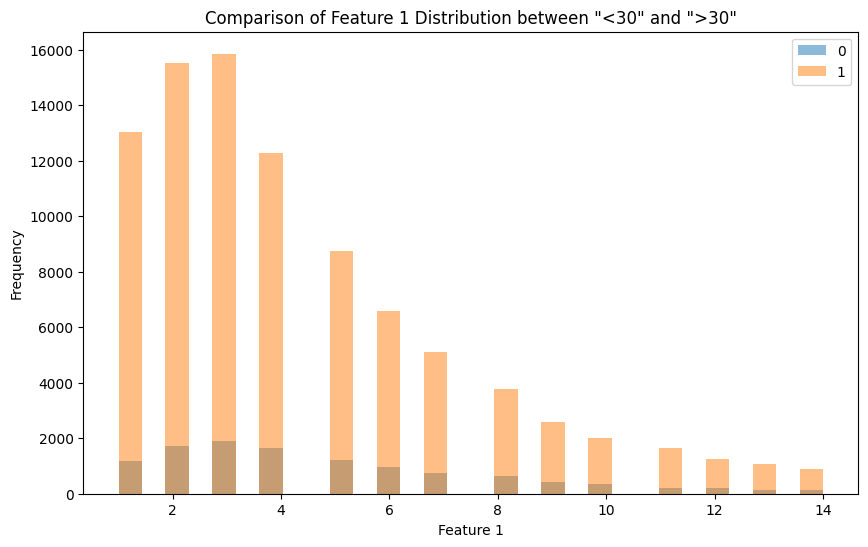

F-value: 147.8253894510799
P-value: 5.5688510585461525e-34
Feature Importances: [4.55023798e-02 2.51245378e-02 1.11782043e-02 3.05835000e-02
 9.94886212e-03 6.91742644e-01 2.72390820e-02 9.07670047e-04
 2.80881168e-04 4.82773962e-02 3.18793031e-02 3.24979970e-02
 1.43410538e-02 6.64910254e-03 1.25894231e-02 8.78159891e-07
 1.12570853e-02]
Mean Feature Values:
Class '0': [ 4.76824866 44.226028    1.28088404 16.90314344  0.43691116  1.22400282
  7.69278859  1.60931584  0.45830765  6.17601479  6.17689531  6.07546007
  5.78814828  1.16632914  1.4116404   0.5106102   0.80223651]
Class '1': [ 4.34922408 42.953644    1.34712252 15.91113717  0.36087115  0.56164762
  7.38866706  1.59745158  0.46296276  6.08673915  6.37849108  5.97651782
  5.66199162  1.1992722   1.40469422  0.54149476  0.76598569]
Selected Feature Indices: [ 0  3  5  6 16]


In [ ]:
# 'target' tiene las siguientes clases: '<30', '>30', 'NO'
# Vamos a filtrar para comparar solo '<30' y '>30'
y_binary = np.where(target == '<30', '<30', '>30')

# Codificar las etiquetas de clase en valores numéricos
le = LabelEncoder()
y_binary = le.fit_transform(y_binary)

# Convertir data y target a arrays NumPy
data = data.values if isinstance(data, pd.DataFrame) else data
target = target.values if isinstance(target, pd.Series) else target

# Dividir los datos en conjuntos de entrenamiento y prueba
data_train, data_test, target_train, target_test = train_test_split(data, y_binary, random_state=42, test_size=0.25)

# Comparación directa de distribuciones
plt.figure(figsize=(10, 6))
for label in np.unique(y_binary):
    plt.hist(data[y_binary == label, 0], bins=30, alpha=0.5, label=label)
plt.xlabel('Feature 1')
plt.ylabel('Frequency')
plt.title('Comparison of Feature 1 Distribution between "<30" and ">30"')
plt.legend()
plt.show()

# Pruebas estadísticas específicas
# Por ejemplo, utilizando ANOVA para comparar la media de la primera característica
f_value, p_value = f_classif(data_train, target_train)
print("F-value:", f_value[0])
print("P-value:", p_value[0])

# Análisis de importancia de características
# Utilizando GradientBoostingClassifier para calcular la importancia de las características
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(data_train, target_train)
feature_importances = gb.feature_importances_
print("Feature Importances:", feature_importances)


# Calculando los perfiles de características promedio para "<30" y ">30"
mean_feature_values = {}
for label in np.unique(y_binary):
    mean_feature_values[label] = np.mean(data[y_binary == label], axis=0)
print("Mean Feature Values:")
for label, mean_values in mean_feature_values.items():
    print(f"Class '{label}':", mean_values)

# 5. Selección de características específicas
# Utilizando SelectKBest con ANOVA para seleccionar las mejores características
selector = SelectKBest(score_func=f_classif, k=5)
data_train_selected = selector.fit_transform(data_train, target_train)
selected_feature_indices = selector.get_support(indices=True)
print("Selected Feature Indices:", selected_feature_indices)



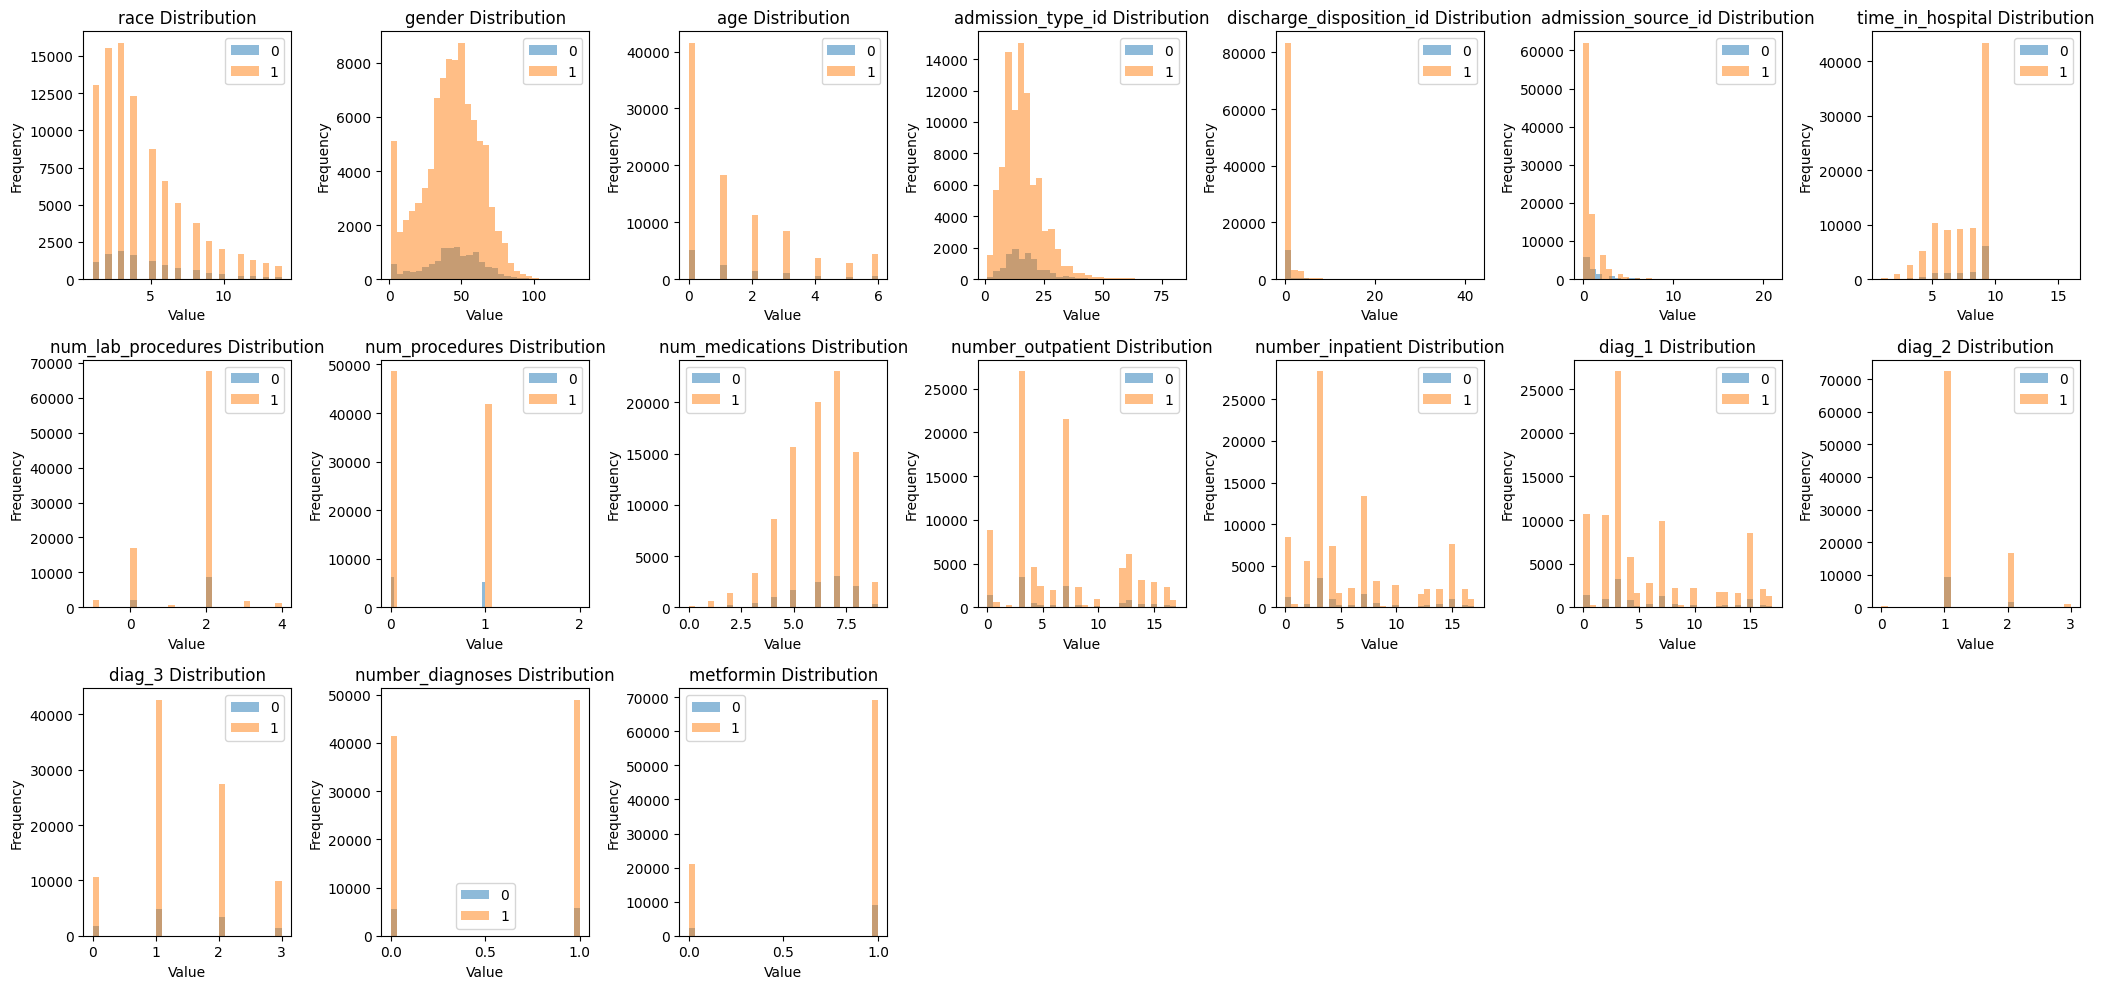

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Obtener los nombres de las características del DataFrame
feature_names = diabetic_data.columns

# Calcular el número de filas y columnas necesarias para acomodar todos los subgráficos
num_features = data.shape[1]
num_rows = num_features // 7 + (1 if num_features % 7 != 0 else 0)
num_cols = min(num_features, 7)

# Comparación directa de distribuciones para todas las características
plt.figure(figsize=(21, 10))
for i in range(num_features):
    plt.subplot(num_rows, num_cols, i+1)
    for label in np.unique(y_binary):
        plt.hist(data[y_binary == label, i], bins=30, alpha=0.5, label=label)
    plt.title(f'{feature_names[i]} Distribution')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.show()


las variablaes
glimepiride-pioglitazona
metformin-rosiglitazone
troglitazone
acarbosa
tolazamide
distribution insuline
glyburide-metformin
glipizide-metformin
glimepiride
acetohexamide, glipizide, glyburide, tolbutamide,pioglitazone, rosiglitazone, glimepiride,
diag_1, diag_2, diag_3, number_diagnoses, metformin, repaglinide, nateglinide, chlorpropamide,